<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/main/Predict_price_after_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ZM_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv to ZM_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
Saving Z_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv to Z_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
Saving Y_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv to Y_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
Saving XPEV_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv to XPEV_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
Saving XOM_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv to XOM_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
Saving X_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv to X_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
Saving WMT_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv to WMT_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
Savi

## Import packages

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Get data at pattern for training & testing

In [ ]:
import io
import pandas as pd

price_patterns_df = pd.DataFrame()
for filename in uploaded.keys():
    print(filename)
    if 'double_top_data_patterns.csv' not in filename:
    # if 'data_patterns.csv' not in filename:
        print('Skipping file', filename)
        continue
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),
                     header=None)
    price_patterns_df = price_patterns_df.append(df)

price_patterns_df = price_patterns_df.sample(frac=1).reset_index(drop=True)
price_patterns_df

ZM_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
Z_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
Y_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
XPEV_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
XOM_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
X_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
WMT_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
WFC_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
W_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
VZ_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
VXRT_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
VICI_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
VIAC_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
V_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
TSLA_2000-01-01 00_00_00_2021-05-29_30_double_top_data_patterns.csv
T_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,187.880005,187.380005,189.360001,190.070007,190.100006,191.229996,190.410004,191.160004,192.990005,192.250000,192.000000,192.300003,191.559998,191.949997,190.679993,191.199997,190.139999,189.990005,191.539993,191.720001,191.279999,191.809998,192.960007,192.800003,193.750000,194.000000,193.110001,191.619995,192.309998,189.009995,190.059998
1,27.559999,27.680000,27.889999,27.870001,27.980000,28.219999,28.190001,28.120001,28.420000,28.340000,28.389999,27.160000,27.620001,27.780001,27.700001,27.610001,27.570000,27.080000,26.820000,26.990000,27.290001,27.340000,27.490000,27.330000,27.129999,27.100000,26.200001,26.200001,26.100000,25.410000,25.559999
2,378.000000,378.000000,378.000000,362.880005,370.440002,340.200012,294.839996,287.279999,279.720001,279.720001,257.040009,257.040009,257.040009,257.040009,257.040009,272.160004,272.160004,257.040009,272.160004,264.600006,264.600006,272.160004,279.720001,279.720001,279.720001,279.720001,264.600006,279.720001,272.160004,264.600006,264.600006
3,61.630001,62.250000,61.630001,62.250000,61.790001,61.500000,60.000000,61.380001,62.160000,62.000000,61.750000,61.750000,61.380001,61.380001,61.599998,61.000000,61.750000,61.849998,61.849998,63.160000,62.500000,62.500000,62.000000,62.139999,61.000000,62.000000,61.349998,62.299999,61.380001,61.130001,60.900002
4,34.430000,34.380001,34.450001,34.090000,34.520000,34.900002,35.080002,36.259998,36.130001,36.450001,37.049999,37.299999,37.009998,36.919998,37.220001,37.669998,38.130001,37.689999,37.840000,37.840000,37.570000,37.220001,37.000000,37.369999,37.509998,37.299999,37.380001,37.580002,37.169998,36.970001,37.139999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7091,45.990002,46.320000,46.849998,46.619999,46.730000,46.330002,46.490002,46.709999,46.759998,47.099998,47.150002,47.360001,47.049999,46.740002,46.580002,46.830002,46.840000,46.880001,46.930000,46.779999,46.700001,46.939999,46.840000,46.810001,47.090000,47.070000,46.660000,46.770000,46.750000,46.320000,45.950001
7092,82.730003,83.349998,83.360001,82.879997,83.120003,82.040001,82.250000,81.870003,82.449997,82.150002,81.580002,82.809998,82.500000,82.349998,83.169998,82.029999,81.750000,81.919998,82.220001,82.510002,81.620003,80.580002,80.650002,80.360001,82.510002,82.879997,83.239998,81.870003,81.879997,78.379997,78.570000
7093,23.870001,24.059999,24.330000,24.580000,24.920000,25.650000,25.219999,25.160000,24.240000,24.980000,24.870001,25.059999,25.040001,25.580000,25.600000,25.040001,25.910000,26.200001,25.570000,25.040001,25.100000,25.830000,25.690001,25.450001,25.639999,24.920000,24.600000,25.170000,24.639999,23.559999,22.520000
7094,14.404828,13.801790,13.743431,13.471091,14.093582,13.529450,13.189025,13.296016,14.900875,13.743431,13.908780,13.918507,13.879601,14.472913,15.348290,15.066224,14.978686,14.618809,14.716073,15.144036,14.745252,14.852243,15.037045,15.591451,14.764705,14.803611,14.764705,15.105130,14.628535,14.404828,14.609083


In [ ]:
#@title Check if data is nearly formed a line
#@markdown ### Delta price distance from data point to trend line
trend_delta = 0.05 #@param {type:"number"}

def is_trend(x_data, y_data):
    assert len(x_data) == len(y_data)
    if len(x_data) < 2:
        return False
    # print(x_data)
    # print(y_data)
    # Find the line from the first to the last point
    # y = a * x + b
    x1, y1 = x_data[0], y_data[0]
    x2, y2 = x_data[-1], y_data[-1]
    a = (y1 - y2) / (x1 - x2)  # slope
    b = y1 - a * x1  # intercept
    b_is_trend = True
    for i in range(len(x_data)):
        y_val = a * x_data[i] + b
        err = abs(y_val - y_data[i])
        if (err > trend_delta * y_val):
            b_is_trend = False
            break
    return b_is_trend
    # p, res, _, _, _ = np.polyfit(x_data, y_data, 1, full=True)
    # err = res[0] if res.size > 0 else 0
    # if err <= len(x_data) * trend_delta:
    #     return True
    # return False

In [ ]:
#@markdown ### Delta price distance between 2 tops/bottoms
y_delta =  0.5#@param {type:"number"}
min_height = 0.5 #@param {type:"number"}

In [ ]:
def find_double_top(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_tops = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            # if l == 301 and r == 307:
            #     print(y_data[l], y_data[r], max(y_data[key_points[i + 1: j]]))
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and min(y_data[l], y_data[r]) >= max(y_data[key_points[i + 1: j]]):
                k_bottom = np.argmin(y_data[l + 1: r]) + l + 1
                if min(y_data[l], y_data[r]) < y_data[k_bottom] + min_height:
                    continue
                (ilows,) = np.where(y_data[:l] <= y_data[k_bottom])
                istart = None
                if ilows.size > 0:
                    istart = ilows[-1]
                (ilows,) = np.where(y_data[r:] <= y_data[k_bottom])
                iend = None
                if ilows.size > 0:
                    iend = ilows[0] + r
                # print(istart, l, k_bottom, r, iend)
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_tops.append((istart, l, k_bottom, r, iend))
    return suspected_double_tops

In [ ]:
def find_double_bottom(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_bottoms = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and max(y_data[l], y_data[r]) <= min(y_data[key_points[i + 1: j]]):
                k_top = np.argmax(y_data[l + 1: r]) + l + 1
                if max(y_data[l], y_data[r]) + min_height > y_data[k_top]:
                    continue
                (ihights,) = np.where(y_data[:l] >= y_data[k_top])
                istart = None
                if ihights.size > 0:
                    istart = ihights[-1]
                (ihights,) = np.where(y_data[r:] >= y_data[k_top])
                iend = None
                if ihights.size > 0:
                    iend = ihights[0] + r
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_bottoms.append((istart, l, k_top, r, iend))
    return suspected_double_bottoms

In [ ]:
for i, row in price_patterns_df.iterrows():
    double_tops = find_double_top(range(len(row)), row.to_numpy())
    double_bots = find_double_bottom(range(len(row)), row.to_numpy())
    print(i, double_tops, double_bots)

Streaming output truncated to the last 5000 lines.
2096 [] []
2097 [(25, 26, 27, 28, 29)] [(24, 25, 26, 27, 28)]
2098 [(22, 23, 24, 25, 29)] []
2099 [] [(2, 4, 7, 8, 11)]
2100 [(23, 25, 26, 27, 29)] []
2101 [(12, 14, 15, 19, 29), (12, 14, 15, 23, 29), (12, 14, 15, 27, 29)] []
2102 [] [(13, 15, 16, 17, 19)]
2103 [] []
2104 [(21, 24, 25, 26, 29)] [(15, 16, 18, 21, 22)]
2105 [] []
2106 [(23, 24, 26, 28, 29)] [(4, 9, 10, 12, 21)]
2107 [(11, 16, 25, 27, 29)] [(21, 22, 24, 25, 26)]
2108 [(5, 8, 9, 11, 15), (20, 21, 23, 25, 29)] []
2109 [(24, 26, 27, 28, 29)] []
2110 [(24, 25, 26, 28, 29)] []
2111 [(5, 7, 13, 15, 29), (5, 9, 13, 15, 29), (13, 15, 16, 20, 23)] [(3, 5, 7, 11, 14), (3, 5, 7, 13, 14)]
2112 [] []
2113 [(5, 7, 12, 17, 28), (16, 17, 19, 20, 22), (13, 20, 24, 26, 28)] [(4, 5, 7, 9, 17), (4, 5, 7, 12, 17), (4, 5, 7, 13, 17)]
2114 [(18, 24, 26, 27, 29)] []
2115 [(8, 9, 15, 22, 29)] []
2116 [] []
2117 [] []
2118 [(3, 4, 6, 10, 13), (23, 24, 26, 27, 29)] [(4, 6, 7, 8, 10)]
2119 [(18, 20,

In [ ]:
#@title Separate into input and output columns: Get data: X and y

X_df = price_patterns_df[price_patterns_df.columns[:-1]]
y_df = price_patterns_df[price_patterns_df.columns[-1:]]
print(X_df)
print(y_df)

X_data = X_df.values
y_data = y_df.values
print(X_data)
print(y_data)

              0           1           2   ...          27          28          29
0     187.880005  187.380005  189.360001  ...  191.619995  192.309998  189.009995
1      27.559999   27.680000   27.889999  ...   26.200001   26.100000   25.410000
2     378.000000  378.000000  378.000000  ...  279.720001  272.160004  264.600006
3      61.630001   62.250000   61.630001  ...   62.299999   61.380001   61.130001
4      34.430000   34.380001   34.450001  ...   37.580002   37.169998   36.970001
...          ...         ...         ...  ...         ...         ...         ...
7091   45.990002   46.320000   46.849998  ...   46.770000   46.750000   46.320000
7092   82.730003   83.349998   83.360001  ...   81.870003   81.879997   78.379997
7093   23.870001   24.059999   24.330000  ...   25.170000   24.639999   23.559999
7094   14.404828   13.801790   13.743431  ...   15.105130   14.628535   14.404828
7095   15.714286   15.714286   15.714286  ...   15.600000   15.600000   15.200000

[7096 rows x 30

In [ ]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
n_data = len(X_data)
n_train = int(train_ratio * n_data)
n_test = n_data - n_train
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax"]

X_train, y_train = X_data[: n_train], y_data[: n_train]
X_test, y_test = X_data[n_train:], y_data[n_train:]
if scale_method == 'MinMax':
    sc_train = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_train.fit_transform(X_train.T).T
    y_train_scaled = sc_train.transform(y_train.T).T
    sc_test = MinMaxScaler(feature_range = (0, 1))
    X_test_scaled = sc_test.fit_transform(X_test.T).T
    y_test_scaled = sc_test.transform(y_test.T).T
    # X_train, y_train = X_train_scaled, y_train_scaled
    # X_test, y_test = X_test_scaled, y_test_scaled
print(X_train.shape, y_train.shape)
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_test.shape, y_test.shape)
print(X_test_scaled.shape, y_test_scaled.shape)

# print(X_train)
# print(y_train)

(5676, 30) (5676, 1)
(5676, 30) (5676, 1)
(1420, 30) (1420, 1)
(1420, 30) (1420, 1)


## LSTM model

### Build model

In [ ]:
#@title Build & fit model
lstm_units = 50 #@param {type:"integer"}
dropout_prob = 0.5 #@param {type:"number"}
epochs = 6000 #@param {type:"integer"}
batch_size = 32768 #@param {type:"integer"}



### Train model

Epoch 1/6000
1/1 [==============================] - 25s 25s/step - loss: 0.2441 - val_loss: 0.1929

Epoch 00001: val_loss improved from inf to 0.19291, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.2011 - val_loss: 0.1575

Epoch 00002: val_loss improved from 0.19291 to 0.15745, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.1686 - val_loss: 0.1335

Epoch 00003: val_loss improved from 0.15745 to 0.13351, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 4/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.1493 - val_loss: 0.1307

Epoch 00004: val_loss improved from 0.13351 to 0.13073, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 5/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.1526 - val_loss: 0.1356

Epoch 00005: val_loss did not improve from 0.13073
Epoch 6/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.1594 - val_loss: 0.1313

Epoch 00006: val_loss did not improve from 0.13073
Epoch 7/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.1543 - val_loss: 0.1252

Epoch 00007: val_loss improved from 0.13073 to 0.12523, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 8/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.1468 - val_loss: 0.1233

Epoch 00008: val_loss improved from 0.12523 to 0.12328, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 9/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.1426 - val_loss: 0.1251

Epoch 00009: val_loss did not improve from 0.12328
Epoch 10/6000
1/1 [==============================] - 0s 123ms/step - loss: 0.1393 - val_loss: 0.1277

Epoch 00010: val_loss did not improve from 0.12328
Epoch 11/6000
1/1 [==============================] - 0s 96ms/step - loss: 0.1422 - val_loss: 0.1289

Epoch 00011: val_loss did not improve from 0.12328
Epoch 12/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.1431 - val_loss: 0.1280

Epoch 00012: val_loss did not improve from 0.12328
Epoch 13/6000
1/1 [==============================] - 0s 96ms/step - loss: 0.1412 - val_loss: 0.1254

Epoch 00013: val_loss did not improve from 0.12328
Epoch 14/6000
1/1 [==============================] - 0s 92ms/step - loss: 0.1391 - val_loss: 0.1220

Epoch 00014: val_loss improved from 0.12328 to 0.12204, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 15/6000
1/1 [==============================] - 0s 124ms/step - loss: 0.1360 - val_loss: 0.1189

Epoch 00015: val_loss improved from 0.12204 to 0.11889, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 16/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.1346 - val_loss: 0.1168

Epoch 00016: val_loss improved from 0.11889 to 0.11676, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 17/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.1330 - val_loss: 0.1158

Epoch 00017: val_loss improved from 0.11676 to 0.11580, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 18/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.1339 - val_loss: 0.1155

Epoch 00018: val_loss improved from 0.11580 to 0.11546, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 19/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.1341 - val_loss: 0.1149

Epoch 00019: val_loss improved from 0.11546 to 0.11486, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 20/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.1340 - val_loss: 0.1137

Epoch 00020: val_loss improved from 0.11486 to 0.11371, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 21/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.1317 - val_loss: 0.1125

Epoch 00021: val_loss improved from 0.11371 to 0.11246, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 22/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.1294 - val_loss: 0.1117

Epoch 00022: val_loss improved from 0.11246 to 0.11169, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 23/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.1285 - val_loss: 0.1116

Epoch 00023: val_loss improved from 0.11169 to 0.11159, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 24/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.1281 - val_loss: 0.1118

Epoch 00024: val_loss did not improve from 0.11159
Epoch 25/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.1260 - val_loss: 0.1119

Epoch 00025: val_loss did not improve from 0.11159
Epoch 26/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.1277 - val_loss: 0.1112

Epoch 00026: val_loss improved from 0.11159 to 0.11119, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 27/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.1254 - val_loss: 0.1096

Epoch 00027: val_loss improved from 0.11119 to 0.10958, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 28/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.1244 - val_loss: 0.1073

Epoch 00028: val_loss improved from 0.10958 to 0.10733, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 29/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.1233 - val_loss: 0.1049

Epoch 00029: val_loss improved from 0.10733 to 0.10490, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 30/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.1218 - val_loss: 0.1027

Epoch 00030: val_loss improved from 0.10490 to 0.10269, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 31/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.1217 - val_loss: 0.1009

Epoch 00031: val_loss improved from 0.10269 to 0.10091, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 32/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.1192 - val_loss: 0.0992

Epoch 00032: val_loss improved from 0.10091 to 0.09920, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 33/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.1192 - val_loss: 0.0973

Epoch 00033: val_loss improved from 0.09920 to 0.09728, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 34/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.1166 - val_loss: 0.0955

Epoch 00034: val_loss improved from 0.09728 to 0.09549, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 35/6000
1/1 [==============================] - 0s 124ms/step - loss: 0.1149 - val_loss: 0.0944

Epoch 00035: val_loss improved from 0.09549 to 0.09435, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 36/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.1140 - val_loss: 0.0935

Epoch 00036: val_loss improved from 0.09435 to 0.09353, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 37/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.1110 - val_loss: 0.0917

Epoch 00037: val_loss improved from 0.09353 to 0.09173, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 38/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.1114 - val_loss: 0.0888

Epoch 00038: val_loss improved from 0.09173 to 0.08880, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 39/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.1109 - val_loss: 0.0861

Epoch 00039: val_loss improved from 0.08880 to 0.08610, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 40/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.1067 - val_loss: 0.0847

Epoch 00040: val_loss improved from 0.08610 to 0.08475, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 41/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.1095 - val_loss: 0.0841

Epoch 00041: val_loss improved from 0.08475 to 0.08409, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 42/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.1070 - val_loss: 0.0848

Epoch 00042: val_loss did not improve from 0.08409
Epoch 43/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.1069 - val_loss: 0.0853

Epoch 00043: val_loss did not improve from 0.08409
Epoch 44/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.1073 - val_loss: 0.0840

Epoch 00044: val_loss improved from 0.08409 to 0.08402, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 45/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.1074 - val_loss: 0.0832

Epoch 00045: val_loss improved from 0.08402 to 0.08322, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 46/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.1077 - val_loss: 0.0831

Epoch 00046: val_loss improved from 0.08322 to 0.08313, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 47/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.1066 - val_loss: 0.0836

Epoch 00047: val_loss did not improve from 0.08313
Epoch 48/6000
1/1 [==============================] - 0s 115ms/step - loss: 0.1051 - val_loss: 0.0844

Epoch 00048: val_loss did not improve from 0.08313
Epoch 49/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.1049 - val_loss: 0.0845

Epoch 00049: val_loss did not improve from 0.08313
Epoch 50/6000
1/1 [==============================] - 0s 98ms/step - loss: 0.1058 - val_loss: 0.0839

Epoch 00050: val_loss did not improve from 0.08313
Epoch 51/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.1069 - val_loss: 0.0837

Epoch 00051: val_loss did not improve from 0.08313
Epoch 52/6000
1/1 [==============================] - 0s 98ms/step - loss: 0.1055 - val_loss: 0.0839

Epoch 00052: val_loss did not improve from 0.08313
Epoch 53/6000
1/1 [==============================] - 0s 97ms/step - loss: 0.1046 - va

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 57/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.1044 - val_loss: 0.0825

Epoch 00057: val_loss improved from 0.08304 to 0.08249, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 58/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.1040 - val_loss: 0.0823

Epoch 00058: val_loss improved from 0.08249 to 0.08230, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 59/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.1034 - val_loss: 0.0823

Epoch 00059: val_loss did not improve from 0.08230
Epoch 60/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.1034 - val_loss: 0.0821

Epoch 00060: val_loss improved from 0.08230 to 0.08211, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 61/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.1027 - val_loss: 0.0817

Epoch 00061: val_loss improved from 0.08211 to 0.08167, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 62/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.1033 - val_loss: 0.0813

Epoch 00062: val_loss improved from 0.08167 to 0.08128, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 63/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.1036 - val_loss: 0.0812

Epoch 00063: val_loss improved from 0.08128 to 0.08117, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 64/6000
1/1 [==============================] - 0s 124ms/step - loss: 0.1024 - val_loss: 0.0812

Epoch 00064: val_loss did not improve from 0.08117
Epoch 65/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.1013 - val_loss: 0.0810

Epoch 00065: val_loss improved from 0.08117 to 0.08100, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 66/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.1026 - val_loss: 0.0806

Epoch 00066: val_loss improved from 0.08100 to 0.08057, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 67/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.1006 - val_loss: 0.0803

Epoch 00067: val_loss improved from 0.08057 to 0.08031, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 68/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.1010 - val_loss: 0.0804

Epoch 00068: val_loss did not improve from 0.08031
Epoch 69/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.1019 - val_loss: 0.0807

Epoch 00069: val_loss did not improve from 0.08031
Epoch 70/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.1012 - val_loss: 0.0805

Epoch 00070: val_loss did not improve from 0.08031
Epoch 71/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.1016 - val_loss: 0.0801

Epoch 00071: val_loss improved from 0.08031 to 0.08012, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 72/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.1010 - val_loss: 0.0799

Epoch 00072: val_loss improved from 0.08012 to 0.07987, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 73/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0999 - val_loss: 0.0797

Epoch 00073: val_loss improved from 0.07987 to 0.07974, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 74/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.1003 - val_loss: 0.0798

Epoch 00074: val_loss did not improve from 0.07974
Epoch 75/6000
1/1 [==============================] - 0s 121ms/step - loss: 0.0999 - val_loss: 0.0797

Epoch 00075: val_loss improved from 0.07974 to 0.07970, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 76/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.1003 - val_loss: 0.0793

Epoch 00076: val_loss improved from 0.07970 to 0.07927, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 77/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0989 - val_loss: 0.0788

Epoch 00077: val_loss improved from 0.07927 to 0.07882, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 78/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0994 - val_loss: 0.0789

Epoch 00078: val_loss did not improve from 0.07882
Epoch 79/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.1009 - val_loss: 0.0791

Epoch 00079: val_loss did not improve from 0.07882
Epoch 80/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0995 - val_loss: 0.0783

Epoch 00080: val_loss improved from 0.07882 to 0.07830, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 81/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.0981 - val_loss: 0.0776

Epoch 00081: val_loss improved from 0.07830 to 0.07760, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 82/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0995 - val_loss: 0.0779

Epoch 00082: val_loss did not improve from 0.07760
Epoch 83/6000
1/1 [==============================] - 0s 122ms/step - loss: 0.0993 - val_loss: 0.0786

Epoch 00083: val_loss did not improve from 0.07760
Epoch 84/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0989 - val_loss: 0.0774

Epoch 00084: val_loss improved from 0.07760 to 0.07736, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 85/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0992 - val_loss: 0.0767

Epoch 00085: val_loss improved from 0.07736 to 0.07672, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 86/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0973 - val_loss: 0.0770

Epoch 00086: val_loss did not improve from 0.07672
Epoch 87/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.0980 - val_loss: 0.0778

Epoch 00087: val_loss did not improve from 0.07672
Epoch 88/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0984 - val_loss: 0.0768

Epoch 00088: val_loss did not improve from 0.07672
Epoch 89/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0971 - val_loss: 0.0759

Epoch 00089: val_loss improved from 0.07672 to 0.07591, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 90/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0979 - val_loss: 0.0762

Epoch 00090: val_loss did not improve from 0.07591
Epoch 91/6000
1/1 [==============================] - 0s 109ms/step - loss: 0.0970 - val_loss: 0.0770

Epoch 00091: val_loss did not improve from 0.07591
Epoch 92/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0969 - val_loss: 0.0759

Epoch 00092: val_loss improved from 0.07591 to 0.07585, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 93/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0968 - val_loss: 0.0752

Epoch 00093: val_loss improved from 0.07585 to 0.07516, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 94/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0967 - val_loss: 0.0753

Epoch 00094: val_loss did not improve from 0.07516
Epoch 95/6000
1/1 [==============================] - 0s 124ms/step - loss: 0.0955 - val_loss: 0.0760

Epoch 00095: val_loss did not improve from 0.07516
Epoch 96/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0978 - val_loss: 0.0749

Epoch 00096: val_loss improved from 0.07516 to 0.07486, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 97/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0952 - val_loss: 0.0741

Epoch 00097: val_loss improved from 0.07486 to 0.07407, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 98/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0968 - val_loss: 0.0751

Epoch 00098: val_loss did not improve from 0.07407
Epoch 99/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0959 - val_loss: 0.0751

Epoch 00099: val_loss did not improve from 0.07407
Epoch 100/6000
1/1 [==============================] - 0s 98ms/step - loss: 0.0956 - val_loss: 0.0732

Epoch 00100: val_loss improved from 0.07407 to 0.07324, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 101/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0960 - val_loss: 0.0739

Epoch 00101: val_loss did not improve from 0.07324
Epoch 102/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.0935 - val_loss: 0.0741

Epoch 00102: val_loss did not improve from 0.07324
Epoch 103/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0944 - val_loss: 0.0728

Epoch 00103: val_loss improved from 0.07324 to 0.07281, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 104/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0930 - val_loss: 0.0723

Epoch 00104: val_loss improved from 0.07281 to 0.07232, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 105/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.0957 - val_loss: 0.0746

Epoch 00105: val_loss did not improve from 0.07232
Epoch 106/6000
1/1 [==============================] - 0s 122ms/step - loss: 0.0942 - val_loss: 0.0720

Epoch 00106: val_loss improved from 0.07232 to 0.07204, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 107/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0929 - val_loss: 0.0716

Epoch 00107: val_loss improved from 0.07204 to 0.07164, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 108/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0943 - val_loss: 0.0745

Epoch 00108: val_loss did not improve from 0.07164
Epoch 109/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0937 - val_loss: 0.0717

Epoch 00109: val_loss did not improve from 0.07164
Epoch 110/6000
1/1 [==============================] - 0s 109ms/step - loss: 0.0929 - val_loss: 0.0708

Epoch 00110: val_loss improved from 0.07164 to 0.07082, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 111/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0946 - val_loss: 0.0750

Epoch 00111: val_loss did not improve from 0.07082
Epoch 112/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.0937 - val_loss: 0.0718

Epoch 00112: val_loss did not improve from 0.07082
Epoch 113/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0927 - val_loss: 0.0705

Epoch 00113: val_loss improved from 0.07082 to 0.07049, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 114/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0943 - val_loss: 0.0725

Epoch 00114: val_loss did not improve from 0.07049
Epoch 115/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0912 - val_loss: 0.0729

Epoch 00115: val_loss did not improve from 0.07049
Epoch 116/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0932 - val_loss: 0.0699

Epoch 00116: val_loss improved from 0.07049 to 0.06990, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 117/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0922 - val_loss: 0.0697

Epoch 00117: val_loss improved from 0.06990 to 0.06970, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 118/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0922 - val_loss: 0.0718

Epoch 00118: val_loss did not improve from 0.06970
Epoch 119/6000
1/1 [==============================] - 0s 124ms/step - loss: 0.0904 - val_loss: 0.0709

Epoch 00119: val_loss did not improve from 0.06970
Epoch 120/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0909 - val_loss: 0.0688

Epoch 00120: val_loss improved from 0.06970 to 0.06877, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 121/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0916 - val_loss: 0.0702

Epoch 00121: val_loss did not improve from 0.06877
Epoch 122/6000
1/1 [==============================] - 0s 124ms/step - loss: 0.0907 - val_loss: 0.0712

Epoch 00122: val_loss did not improve from 0.06877
Epoch 123/6000
1/1 [==============================] - 0s 96ms/step - loss: 0.0917 - val_loss: 0.0685

Epoch 00123: val_loss improved from 0.06877 to 0.06850, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 124/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0908 - val_loss: 0.0682

Epoch 00124: val_loss improved from 0.06850 to 0.06819, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 125/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0914 - val_loss: 0.0707

Epoch 00125: val_loss did not improve from 0.06819
Epoch 126/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.0902 - val_loss: 0.0683

Epoch 00126: val_loss did not improve from 0.06819
Epoch 127/6000
1/1 [==============================] - 0s 97ms/step - loss: 0.0908 - val_loss: 0.0675

Epoch 00127: val_loss improved from 0.06819 to 0.06746, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 128/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0903 - val_loss: 0.0695

Epoch 00128: val_loss did not improve from 0.06746
Epoch 129/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0903 - val_loss: 0.0687

Epoch 00129: val_loss did not improve from 0.06746
Epoch 130/6000
1/1 [==============================] - 0s 98ms/step - loss: 0.0894 - val_loss: 0.0670

Epoch 00130: val_loss improved from 0.06746 to 0.06698, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 131/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0911 - val_loss: 0.0683

Epoch 00131: val_loss did not improve from 0.06698
Epoch 132/6000
1/1 [==============================] - 0s 119ms/step - loss: 0.0896 - val_loss: 0.0685

Epoch 00132: val_loss did not improve from 0.06698
Epoch 133/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0895 - val_loss: 0.0667

Epoch 00133: val_loss improved from 0.06698 to 0.06671, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 134/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0894 - val_loss: 0.0673

Epoch 00134: val_loss did not improve from 0.06671
Epoch 135/6000
1/1 [==============================] - 0s 123ms/step - loss: 0.0886 - val_loss: 0.0677

Epoch 00135: val_loss did not improve from 0.06671
Epoch 136/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0881 - val_loss: 0.0661

Epoch 00136: val_loss improved from 0.06671 to 0.06609, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 137/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0874 - val_loss: 0.0667

Epoch 00137: val_loss did not improve from 0.06609
Epoch 138/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0878 - val_loss: 0.0668

Epoch 00138: val_loss did not improve from 0.06609
Epoch 139/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0875 - val_loss: 0.0653

Epoch 00139: val_loss improved from 0.06609 to 0.06529, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 140/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0875 - val_loss: 0.0665

Epoch 00140: val_loss did not improve from 0.06529
Epoch 141/6000
1/1 [==============================] - 0s 116ms/step - loss: 0.0870 - val_loss: 0.0658

Epoch 00141: val_loss did not improve from 0.06529
Epoch 142/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0872 - val_loss: 0.0652

Epoch 00142: val_loss improved from 0.06529 to 0.06524, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 143/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0873 - val_loss: 0.0655

Epoch 00143: val_loss did not improve from 0.06524
Epoch 144/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.0858 - val_loss: 0.0649

Epoch 00144: val_loss improved from 0.06524 to 0.06491, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 145/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0857 - val_loss: 0.0646

Epoch 00145: val_loss improved from 0.06491 to 0.06458, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 146/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.0868 - val_loss: 0.0664

Epoch 00146: val_loss did not improve from 0.06458
Epoch 147/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0880 - val_loss: 0.0642

Epoch 00147: val_loss improved from 0.06458 to 0.06424, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 148/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0863 - val_loss: 0.0644

Epoch 00148: val_loss did not improve from 0.06424
Epoch 149/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0854 - val_loss: 0.0659

Epoch 00149: val_loss did not improve from 0.06424
Epoch 150/6000
1/1 [==============================] - 0s 98ms/step - loss: 0.0851 - val_loss: 0.0634

Epoch 00150: val_loss improved from 0.06424 to 0.06342, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 151/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0866 - val_loss: 0.0658

Epoch 00151: val_loss did not improve from 0.06342
Epoch 152/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0851 - val_loss: 0.0639

Epoch 00152: val_loss did not improve from 0.06342
Epoch 153/6000
1/1 [==============================] - 0s 111ms/step - loss: 0.0848 - val_loss: 0.0631

Epoch 00153: val_loss improved from 0.06342 to 0.06313, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 154/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0863 - val_loss: 0.0667

Epoch 00154: val_loss did not improve from 0.06313
Epoch 155/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0855 - val_loss: 0.0630

Epoch 00155: val_loss improved from 0.06313 to 0.06302, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 156/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0844 - val_loss: 0.0631

Epoch 00156: val_loss did not improve from 0.06302
Epoch 157/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0841 - val_loss: 0.0653

Epoch 00157: val_loss did not improve from 0.06302
Epoch 158/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0855 - val_loss: 0.0635

Epoch 00158: val_loss did not improve from 0.06302
Epoch 159/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0855 - val_loss: 0.0625

Epoch 00159: val_loss improved from 0.06302 to 0.06250, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 160/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0854 - val_loss: 0.0643

Epoch 00160: val_loss did not improve from 0.06250
Epoch 161/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0842 - val_loss: 0.0633

Epoch 00161: val_loss did not improve from 0.06250
Epoch 162/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0839 - val_loss: 0.0620

Epoch 00162: val_loss improved from 0.06250 to 0.06200, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 163/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0846 - val_loss: 0.0649

Epoch 00163: val_loss did not improve from 0.06200
Epoch 164/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0836 - val_loss: 0.0628

Epoch 00164: val_loss did not improve from 0.06200
Epoch 165/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0838 - val_loss: 0.0618

Epoch 00165: val_loss improved from 0.06200 to 0.06180, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 166/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0836 - val_loss: 0.0636

Epoch 00166: val_loss did not improve from 0.06180
Epoch 167/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0831 - val_loss: 0.0627

Epoch 00167: val_loss did not improve from 0.06180
Epoch 168/6000
1/1 [==============================] - 0s 109ms/step - loss: 0.0834 - val_loss: 0.0615

Epoch 00168: val_loss improved from 0.06180 to 0.06152, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 169/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0839 - val_loss: 0.0629

Epoch 00169: val_loss did not improve from 0.06152
Epoch 170/6000
1/1 [==============================] - 0s 115ms/step - loss: 0.0825 - val_loss: 0.0624

Epoch 00170: val_loss did not improve from 0.06152
Epoch 171/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0827 - val_loss: 0.0613

Epoch 00171: val_loss improved from 0.06152 to 0.06130, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 172/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0833 - val_loss: 0.0629

Epoch 00172: val_loss did not improve from 0.06130
Epoch 173/6000
1/1 [==============================] - 0s 119ms/step - loss: 0.0827 - val_loss: 0.0619

Epoch 00173: val_loss did not improve from 0.06130
Epoch 174/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0814 - val_loss: 0.0609

Epoch 00174: val_loss improved from 0.06130 to 0.06093, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 175/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0826 - val_loss: 0.0630

Epoch 00175: val_loss did not improve from 0.06093
Epoch 176/6000
1/1 [==============================] - 0s 115ms/step - loss: 0.0838 - val_loss: 0.0617

Epoch 00176: val_loss did not improve from 0.06093
Epoch 177/6000
1/1 [==============================] - 0s 97ms/step - loss: 0.0827 - val_loss: 0.0608

Epoch 00177: val_loss improved from 0.06093 to 0.06084, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 178/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0820 - val_loss: 0.0625

Epoch 00178: val_loss did not improve from 0.06084
Epoch 179/6000
1/1 [==============================] - 0s 121ms/step - loss: 0.0821 - val_loss: 0.0615

Epoch 00179: val_loss did not improve from 0.06084
Epoch 180/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0820 - val_loss: 0.0607

Epoch 00180: val_loss improved from 0.06084 to 0.06072, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 181/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0819 - val_loss: 0.0619

Epoch 00181: val_loss did not improve from 0.06072
Epoch 182/6000
1/1 [==============================] - 0s 119ms/step - loss: 0.0813 - val_loss: 0.0611

Epoch 00182: val_loss did not improve from 0.06072
Epoch 183/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0813 - val_loss: 0.0605

Epoch 00183: val_loss improved from 0.06072 to 0.06048, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 184/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0805 - val_loss: 0.0609

Epoch 00184: val_loss did not improve from 0.06048
Epoch 185/6000
1/1 [==============================] - 0s 121ms/step - loss: 0.0820 - val_loss: 0.0609

Epoch 00185: val_loss did not improve from 0.06048
Epoch 186/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.0813 - val_loss: 0.0604

Epoch 00186: val_loss improved from 0.06048 to 0.06039, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 187/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0812 - val_loss: 0.0607

Epoch 00187: val_loss did not improve from 0.06039
Epoch 188/6000
1/1 [==============================] - 0s 115ms/step - loss: 0.0812 - val_loss: 0.0604

Epoch 00188: val_loss improved from 0.06039 to 0.06038, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 189/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0809 - val_loss: 0.0603

Epoch 00189: val_loss improved from 0.06038 to 0.06030, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 190/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0808 - val_loss: 0.0600

Epoch 00190: val_loss improved from 0.06030 to 0.06004, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 191/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0799 - val_loss: 0.0602

Epoch 00191: val_loss did not improve from 0.06004
Epoch 192/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0795 - val_loss: 0.0600

Epoch 00192: val_loss improved from 0.06004 to 0.06000, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 193/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0809 - val_loss: 0.0599

Epoch 00193: val_loss improved from 0.06000 to 0.05987, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 194/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0795 - val_loss: 0.0605

Epoch 00194: val_loss did not improve from 0.05987
Epoch 195/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0802 - val_loss: 0.0594

Epoch 00195: val_loss improved from 0.05987 to 0.05937, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 196/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0798 - val_loss: 0.0592

Epoch 00196: val_loss improved from 0.05937 to 0.05923, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 197/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0808 - val_loss: 0.0601

Epoch 00197: val_loss did not improve from 0.05923
Epoch 198/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0800 - val_loss: 0.0600

Epoch 00198: val_loss did not improve from 0.05923
Epoch 199/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0805 - val_loss: 0.0593

Epoch 00199: val_loss did not improve from 0.05923
Epoch 200/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0796 - val_loss: 0.0595

Epoch 00200: val_loss did not improve from 0.05923
Epoch 201/6000
1/1 [==============================] - 0s 98ms/step - loss: 0.0799 - val_loss: 0.0597

Epoch 00201: val_loss did not improve from 0.05923
Epoch 202/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0790 - val_loss: 0.0591

Epoch 00202: val_loss improved from 0.05923 to 0.05913, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 203/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0794 - val_loss: 0.0588

Epoch 00203: val_loss improved from 0.05913 to 0.05875, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 204/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0794 - val_loss: 0.0597

Epoch 00204: val_loss did not improve from 0.05875
Epoch 205/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0795 - val_loss: 0.0586

Epoch 00205: val_loss improved from 0.05875 to 0.05860, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 206/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0792 - val_loss: 0.0584

Epoch 00206: val_loss improved from 0.05860 to 0.05840, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 207/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0797 - val_loss: 0.0600

Epoch 00207: val_loss did not improve from 0.05840
Epoch 208/6000
1/1 [==============================] - 0s 123ms/step - loss: 0.0789 - val_loss: 0.0585

Epoch 00208: val_loss did not improve from 0.05840
Epoch 209/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0784 - val_loss: 0.0579

Epoch 00209: val_loss improved from 0.05840 to 0.05792, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 210/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0778 - val_loss: 0.0593

Epoch 00210: val_loss did not improve from 0.05792
Epoch 211/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.0786 - val_loss: 0.0589

Epoch 00211: val_loss did not improve from 0.05792
Epoch 212/6000
1/1 [==============================] - 0s 111ms/step - loss: 0.0793 - val_loss: 0.0577

Epoch 00212: val_loss improved from 0.05792 to 0.05767, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 213/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0771 - val_loss: 0.0588

Epoch 00213: val_loss did not improve from 0.05767
Epoch 214/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0781 - val_loss: 0.0582

Epoch 00214: val_loss did not improve from 0.05767
Epoch 215/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0785 - val_loss: 0.0576

Epoch 00215: val_loss improved from 0.05767 to 0.05763, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 216/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0792 - val_loss: 0.0582

Epoch 00216: val_loss did not improve from 0.05763
Epoch 217/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0781 - val_loss: 0.0579

Epoch 00217: val_loss did not improve from 0.05763
Epoch 218/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0771 - val_loss: 0.0574

Epoch 00218: val_loss improved from 0.05763 to 0.05745, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 219/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0778 - val_loss: 0.0580

Epoch 00219: val_loss did not improve from 0.05745
Epoch 220/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.0774 - val_loss: 0.0575

Epoch 00220: val_loss did not improve from 0.05745
Epoch 221/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0766 - val_loss: 0.0569

Epoch 00221: val_loss improved from 0.05745 to 0.05685, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 222/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0775 - val_loss: 0.0582

Epoch 00222: val_loss did not improve from 0.05685
Epoch 223/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0784 - val_loss: 0.0572

Epoch 00223: val_loss did not improve from 0.05685
Epoch 224/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0774 - val_loss: 0.0569

Epoch 00224: val_loss did not improve from 0.05685
Epoch 225/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0769 - val_loss: 0.0571

Epoch 00225: val_loss did not improve from 0.05685
Epoch 226/6000
1/1 [==============================] - 0s 95ms/step - loss: 0.0772 - val_loss: 0.0572

Epoch 00226: val_loss did not improve from 0.05685
Epoch 227/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0769 - val_loss: 0.0569

Epoch 00227: val_loss did not improve from 0.05685
Epoch 228/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 230/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0767 - val_loss: 0.0570

Epoch 00230: val_loss did not improve from 0.05661
Epoch 231/6000
1/1 [==============================] - 0s 122ms/step - loss: 0.0780 - val_loss: 0.0562

Epoch 00231: val_loss improved from 0.05661 to 0.05623, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 232/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0759 - val_loss: 0.0563

Epoch 00232: val_loss did not improve from 0.05623
Epoch 233/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0763 - val_loss: 0.0568

Epoch 00233: val_loss did not improve from 0.05623
Epoch 234/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0761 - val_loss: 0.0557

Epoch 00234: val_loss improved from 0.05623 to 0.05571, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 235/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0760 - val_loss: 0.0565

Epoch 00235: val_loss did not improve from 0.05571
Epoch 236/6000
1/1 [==============================] - 0s 124ms/step - loss: 0.0763 - val_loss: 0.0563

Epoch 00236: val_loss did not improve from 0.05571
Epoch 237/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0761 - val_loss: 0.0555

Epoch 00237: val_loss improved from 0.05571 to 0.05554, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 238/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0757 - val_loss: 0.0562

Epoch 00238: val_loss did not improve from 0.05554
Epoch 239/6000
1/1 [==============================] - 0s 115ms/step - loss: 0.0754 - val_loss: 0.0560

Epoch 00239: val_loss did not improve from 0.05554
Epoch 240/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0756 - val_loss: 0.0551

Epoch 00240: val_loss improved from 0.05554 to 0.05510, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 241/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0760 - val_loss: 0.0564

Epoch 00241: val_loss did not improve from 0.05510
Epoch 242/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0758 - val_loss: 0.0555

Epoch 00242: val_loss did not improve from 0.05510
Epoch 243/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0746 - val_loss: 0.0549

Epoch 00243: val_loss improved from 0.05510 to 0.05489, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 244/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0761 - val_loss: 0.0558

Epoch 00244: val_loss did not improve from 0.05489
Epoch 245/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.0748 - val_loss: 0.0557

Epoch 00245: val_loss did not improve from 0.05489
Epoch 246/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0744 - val_loss: 0.0545

Epoch 00246: val_loss improved from 0.05489 to 0.05447, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 247/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0758 - val_loss: 0.0557

Epoch 00247: val_loss did not improve from 0.05447
Epoch 248/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0741 - val_loss: 0.0554

Epoch 00248: val_loss did not improve from 0.05447
Epoch 249/6000
1/1 [==============================] - 0s 109ms/step - loss: 0.0744 - val_loss: 0.0541

Epoch 00249: val_loss improved from 0.05447 to 0.05413, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 250/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0753 - val_loss: 0.0556

Epoch 00250: val_loss did not improve from 0.05413
Epoch 251/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0750 - val_loss: 0.0551

Epoch 00251: val_loss did not improve from 0.05413
Epoch 252/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0743 - val_loss: 0.0538

Epoch 00252: val_loss improved from 0.05413 to 0.05380, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 253/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0746 - val_loss: 0.0544

Epoch 00253: val_loss did not improve from 0.05380
Epoch 254/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0735 - val_loss: 0.0556

Epoch 00254: val_loss did not improve from 0.05380
Epoch 255/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0738 - val_loss: 0.0536

Epoch 00255: val_loss improved from 0.05380 to 0.05355, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 256/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0732 - val_loss: 0.0533

Epoch 00256: val_loss improved from 0.05355 to 0.05332, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 257/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0729 - val_loss: 0.0551

Epoch 00257: val_loss did not improve from 0.05332
Epoch 258/6000
1/1 [==============================] - 0s 122ms/step - loss: 0.0732 - val_loss: 0.0543

Epoch 00258: val_loss did not improve from 0.05332
Epoch 259/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0741 - val_loss: 0.0530

Epoch 00259: val_loss improved from 0.05332 to 0.05296, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 260/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0743 - val_loss: 0.0534

Epoch 00260: val_loss did not improve from 0.05296
Epoch 261/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0731 - val_loss: 0.0543

Epoch 00261: val_loss did not improve from 0.05296
Epoch 262/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0738 - val_loss: 0.0527

Epoch 00262: val_loss improved from 0.05296 to 0.05275, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 263/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0734 - val_loss: 0.0525

Epoch 00263: val_loss improved from 0.05275 to 0.05246, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 264/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0736 - val_loss: 0.0533

Epoch 00264: val_loss did not improve from 0.05246
Epoch 265/6000
1/1 [==============================] - 0s 124ms/step - loss: 0.0719 - val_loss: 0.0530

Epoch 00265: val_loss did not improve from 0.05246
Epoch 266/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0710 - val_loss: 0.0521

Epoch 00266: val_loss improved from 0.05246 to 0.05209, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 267/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0719 - val_loss: 0.0526

Epoch 00267: val_loss did not improve from 0.05209
Epoch 268/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0729 - val_loss: 0.0529

Epoch 00268: val_loss did not improve from 0.05209
Epoch 269/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0720 - val_loss: 0.0519

Epoch 00269: val_loss improved from 0.05209 to 0.05188, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 270/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0721 - val_loss: 0.0517

Epoch 00270: val_loss improved from 0.05188 to 0.05171, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 271/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0717 - val_loss: 0.0524

Epoch 00271: val_loss did not improve from 0.05171
Epoch 272/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0724 - val_loss: 0.0523

Epoch 00272: val_loss did not improve from 0.05171
Epoch 273/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0714 - val_loss: 0.0513

Epoch 00273: val_loss improved from 0.05171 to 0.05132, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 274/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0715 - val_loss: 0.0513

Epoch 00274: val_loss improved from 0.05132 to 0.05125, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 275/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0723 - val_loss: 0.0521

Epoch 00275: val_loss did not improve from 0.05125
Epoch 276/6000
1/1 [==============================] - 0s 116ms/step - loss: 0.0724 - val_loss: 0.0514

Epoch 00276: val_loss did not improve from 0.05125
Epoch 277/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0713 - val_loss: 0.0507

Epoch 00277: val_loss improved from 0.05125 to 0.05072, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 278/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0717 - val_loss: 0.0512

Epoch 00278: val_loss did not improve from 0.05072
Epoch 279/6000
1/1 [==============================] - 0s 115ms/step - loss: 0.0712 - val_loss: 0.0516

Epoch 00279: val_loss did not improve from 0.05072
Epoch 280/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0703 - val_loss: 0.0503

Epoch 00280: val_loss improved from 0.05072 to 0.05033, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 281/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0711 - val_loss: 0.0502

Epoch 00281: val_loss improved from 0.05033 to 0.05016, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 282/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0711 - val_loss: 0.0513

Epoch 00282: val_loss did not improve from 0.05016
Epoch 283/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0710 - val_loss: 0.0506

Epoch 00283: val_loss did not improve from 0.05016
Epoch 284/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0702 - val_loss: 0.0497

Epoch 00284: val_loss improved from 0.05016 to 0.04966, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 285/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0700 - val_loss: 0.0497

Epoch 00285: val_loss did not improve from 0.04966
Epoch 286/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0692 - val_loss: 0.0505

Epoch 00286: val_loss did not improve from 0.04966
Epoch 287/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0710 - val_loss: 0.0496

Epoch 00287: val_loss improved from 0.04966 to 0.04956, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 288/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0696 - val_loss: 0.0491

Epoch 00288: val_loss improved from 0.04956 to 0.04908, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 289/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0697 - val_loss: 0.0495

Epoch 00289: val_loss did not improve from 0.04908
Epoch 290/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0691 - val_loss: 0.0502

Epoch 00290: val_loss did not improve from 0.04908
Epoch 291/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0695 - val_loss: 0.0492

Epoch 00291: val_loss did not improve from 0.04908
Epoch 292/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0686 - val_loss: 0.0487

Epoch 00292: val_loss improved from 0.04908 to 0.04869, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 293/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0708 - val_loss: 0.0491

Epoch 00293: val_loss did not improve from 0.04869
Epoch 294/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.0692 - val_loss: 0.0494

Epoch 00294: val_loss did not improve from 0.04869
Epoch 295/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0686 - val_loss: 0.0484

Epoch 00295: val_loss improved from 0.04869 to 0.04844, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 296/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0686 - val_loss: 0.0481

Epoch 00296: val_loss improved from 0.04844 to 0.04814, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 297/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0694 - val_loss: 0.0486

Epoch 00297: val_loss did not improve from 0.04814
Epoch 298/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0692 - val_loss: 0.0490

Epoch 00298: val_loss did not improve from 0.04814
Epoch 299/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0684 - val_loss: 0.0478

Epoch 00299: val_loss improved from 0.04814 to 0.04781, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 300/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0693 - val_loss: 0.0474

Epoch 00300: val_loss improved from 0.04781 to 0.04743, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 301/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0690 - val_loss: 0.0479

Epoch 00301: val_loss did not improve from 0.04743
Epoch 302/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0666 - val_loss: 0.0477

Epoch 00302: val_loss did not improve from 0.04743
Epoch 303/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0671 - val_loss: 0.0473

Epoch 00303: val_loss improved from 0.04743 to 0.04726, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 304/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0676 - val_loss: 0.0473

Epoch 00304: val_loss did not improve from 0.04726
Epoch 305/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.0662 - val_loss: 0.0474

Epoch 00305: val_loss did not improve from 0.04726
Epoch 306/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0672 - val_loss: 0.0471

Epoch 00306: val_loss improved from 0.04726 to 0.04706, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 307/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0664 - val_loss: 0.0469

Epoch 00307: val_loss improved from 0.04706 to 0.04690, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 308/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0673 - val_loss: 0.0468

Epoch 00308: val_loss improved from 0.04690 to 0.04681, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 309/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0672 - val_loss: 0.0467

Epoch 00309: val_loss improved from 0.04681 to 0.04665, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 310/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0667 - val_loss: 0.0465

Epoch 00310: val_loss improved from 0.04665 to 0.04651, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 311/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0687 - val_loss: 0.0466

Epoch 00311: val_loss did not improve from 0.04651
Epoch 312/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0675 - val_loss: 0.0463

Epoch 00312: val_loss improved from 0.04651 to 0.04628, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 313/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0673 - val_loss: 0.0460

Epoch 00313: val_loss improved from 0.04628 to 0.04603, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 314/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0670 - val_loss: 0.0462

Epoch 00314: val_loss did not improve from 0.04603
Epoch 315/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0673 - val_loss: 0.0463

Epoch 00315: val_loss did not improve from 0.04603
Epoch 316/6000
1/1 [==============================] - 0s 109ms/step - loss: 0.0676 - val_loss: 0.0458

Epoch 00316: val_loss improved from 0.04603 to 0.04583, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 317/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0665 - val_loss: 0.0456

Epoch 00317: val_loss improved from 0.04583 to 0.04563, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 318/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0668 - val_loss: 0.0458

Epoch 00318: val_loss did not improve from 0.04563
Epoch 319/6000
1/1 [==============================] - 0s 116ms/step - loss: 0.0652 - val_loss: 0.0457

Epoch 00319: val_loss did not improve from 0.04563
Epoch 320/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0652 - val_loss: 0.0453

Epoch 00320: val_loss improved from 0.04563 to 0.04526, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 321/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0660 - val_loss: 0.0452

Epoch 00321: val_loss improved from 0.04526 to 0.04516, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 322/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0663 - val_loss: 0.0452

Epoch 00322: val_loss did not improve from 0.04516
Epoch 323/6000
1/1 [==============================] - 0s 123ms/step - loss: 0.0659 - val_loss: 0.0452

Epoch 00323: val_loss did not improve from 0.04516
Epoch 324/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0670 - val_loss: 0.0451

Epoch 00324: val_loss improved from 0.04516 to 0.04513, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 325/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0666 - val_loss: 0.0449

Epoch 00325: val_loss improved from 0.04513 to 0.04489, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 326/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0655 - val_loss: 0.0447

Epoch 00326: val_loss improved from 0.04489 to 0.04468, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 327/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0670 - val_loss: 0.0449

Epoch 00327: val_loss did not improve from 0.04468
Epoch 328/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0659 - val_loss: 0.0447

Epoch 00328: val_loss did not improve from 0.04468
Epoch 329/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0650 - val_loss: 0.0445

Epoch 00329: val_loss improved from 0.04468 to 0.04446, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 330/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0644 - val_loss: 0.0444

Epoch 00330: val_loss improved from 0.04446 to 0.04441, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 331/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0659 - val_loss: 0.0447

Epoch 00331: val_loss did not improve from 0.04441
Epoch 332/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.0654 - val_loss: 0.0445

Epoch 00332: val_loss did not improve from 0.04441
Epoch 333/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0656 - val_loss: 0.0442

Epoch 00333: val_loss improved from 0.04441 to 0.04419, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 334/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0651 - val_loss: 0.0443

Epoch 00334: val_loss did not improve from 0.04419
Epoch 335/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0648 - val_loss: 0.0443

Epoch 00335: val_loss did not improve from 0.04419
Epoch 336/6000
1/1 [==============================] - 0s 115ms/step - loss: 0.0643 - val_loss: 0.0441

Epoch 00336: val_loss improved from 0.04419 to 0.04411, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 337/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0652 - val_loss: 0.0439

Epoch 00337: val_loss improved from 0.04411 to 0.04394, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 338/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0650 - val_loss: 0.0441

Epoch 00338: val_loss did not improve from 0.04394
Epoch 339/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0644 - val_loss: 0.0443

Epoch 00339: val_loss did not improve from 0.04394
Epoch 340/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0650 - val_loss: 0.0440

Epoch 00340: val_loss did not improve from 0.04394
Epoch 341/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0646 - val_loss: 0.0437

Epoch 00341: val_loss improved from 0.04394 to 0.04375, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 342/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0644 - val_loss: 0.0438

Epoch 00342: val_loss did not improve from 0.04375
Epoch 343/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0648 - val_loss: 0.0440

Epoch 00343: val_loss did not improve from 0.04375
Epoch 344/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0651 - val_loss: 0.0439

Epoch 00344: val_loss did not improve from 0.04375
Epoch 345/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0646 - val_loss: 0.0434

Epoch 00345: val_loss improved from 0.04375 to 0.04343, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 346/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0642 - val_loss: 0.0434

Epoch 00346: val_loss improved from 0.04343 to 0.04342, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 347/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0649 - val_loss: 0.0436

Epoch 00347: val_loss did not improve from 0.04342
Epoch 348/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0638 - val_loss: 0.0436

Epoch 00348: val_loss did not improve from 0.04342
Epoch 349/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0638 - val_loss: 0.0432

Epoch 00349: val_loss improved from 0.04342 to 0.04324, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 350/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0632 - val_loss: 0.0431

Epoch 00350: val_loss improved from 0.04324 to 0.04312, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 351/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0629 - val_loss: 0.0433

Epoch 00351: val_loss did not improve from 0.04312
Epoch 352/6000
1/1 [==============================] - 0s 115ms/step - loss: 0.0641 - val_loss: 0.0435

Epoch 00352: val_loss did not improve from 0.04312
Epoch 353/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0635 - val_loss: 0.0432

Epoch 00353: val_loss did not improve from 0.04312
Epoch 354/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0646 - val_loss: 0.0431

Epoch 00354: val_loss improved from 0.04312 to 0.04309, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 355/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0636 - val_loss: 0.0433

Epoch 00355: val_loss did not improve from 0.04309
Epoch 356/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0643 - val_loss: 0.0433

Epoch 00356: val_loss did not improve from 0.04309
Epoch 357/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0637 - val_loss: 0.0431

Epoch 00357: val_loss did not improve from 0.04309
Epoch 358/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0634 - val_loss: 0.0430

Epoch 00358: val_loss improved from 0.04309 to 0.04297, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 359/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0629 - val_loss: 0.0429

Epoch 00359: val_loss improved from 0.04297 to 0.04289, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 360/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0632 - val_loss: 0.0428

Epoch 00360: val_loss improved from 0.04289 to 0.04282, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 361/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0636 - val_loss: 0.0429

Epoch 00361: val_loss did not improve from 0.04282
Epoch 362/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0630 - val_loss: 0.0427

Epoch 00362: val_loss improved from 0.04282 to 0.04271, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 363/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0636 - val_loss: 0.0427

Epoch 00363: val_loss improved from 0.04271 to 0.04270, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 364/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0625 - val_loss: 0.0427

Epoch 00364: val_loss improved from 0.04270 to 0.04270, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 365/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0636 - val_loss: 0.0428

Epoch 00365: val_loss did not improve from 0.04270
Epoch 366/6000
1/1 [==============================] - 0s 122ms/step - loss: 0.0626 - val_loss: 0.0429

Epoch 00366: val_loss did not improve from 0.04270
Epoch 367/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0625 - val_loss: 0.0428

Epoch 00367: val_loss did not improve from 0.04270
Epoch 368/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0624 - val_loss: 0.0426

Epoch 00368: val_loss improved from 0.04270 to 0.04263, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 369/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0633 - val_loss: 0.0426

Epoch 00369: val_loss improved from 0.04263 to 0.04261, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 370/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0636 - val_loss: 0.0425

Epoch 00370: val_loss improved from 0.04261 to 0.04251, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 371/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0630 - val_loss: 0.0424

Epoch 00371: val_loss improved from 0.04251 to 0.04239, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 372/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0623 - val_loss: 0.0424

Epoch 00372: val_loss improved from 0.04239 to 0.04238, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 373/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0633 - val_loss: 0.0424

Epoch 00373: val_loss did not improve from 0.04238
Epoch 374/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0625 - val_loss: 0.0422

Epoch 00374: val_loss improved from 0.04238 to 0.04225, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 375/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0632 - val_loss: 0.0422

Epoch 00375: val_loss improved from 0.04225 to 0.04221, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 376/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0632 - val_loss: 0.0424

Epoch 00376: val_loss did not improve from 0.04221
Epoch 377/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0636 - val_loss: 0.0423

Epoch 00377: val_loss did not improve from 0.04221
Epoch 378/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0621 - val_loss: 0.0422

Epoch 00378: val_loss improved from 0.04221 to 0.04221, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 379/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0626 - val_loss: 0.0422

Epoch 00379: val_loss improved from 0.04221 to 0.04221, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 380/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0637 - val_loss: 0.0423

Epoch 00380: val_loss did not improve from 0.04221
Epoch 381/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0629 - val_loss: 0.0423

Epoch 00381: val_loss did not improve from 0.04221
Epoch 382/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0618 - val_loss: 0.0423

Epoch 00382: val_loss did not improve from 0.04221
Epoch 383/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0625 - val_loss: 0.0422

Epoch 00383: val_loss did not improve from 0.04221
Epoch 384/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0623 - val_loss: 0.0420

Epoch 00384: val_loss improved from 0.04221 to 0.04204, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 385/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0626 - val_loss: 0.0420

Epoch 00385: val_loss improved from 0.04204 to 0.04195, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 386/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0616 - val_loss: 0.0421

Epoch 00386: val_loss did not improve from 0.04195
Epoch 387/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0632 - val_loss: 0.0421

Epoch 00387: val_loss did not improve from 0.04195
Epoch 388/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0623 - val_loss: 0.0419

Epoch 00388: val_loss improved from 0.04195 to 0.04192, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 389/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0615 - val_loss: 0.0419

Epoch 00389: val_loss improved from 0.04192 to 0.04188, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 390/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0619 - val_loss: 0.0421

Epoch 00390: val_loss did not improve from 0.04188
Epoch 391/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0615 - val_loss: 0.0421

Epoch 00391: val_loss did not improve from 0.04188
Epoch 392/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.0617 - val_loss: 0.0419

Epoch 00392: val_loss did not improve from 0.04188
Epoch 393/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0624 - val_loss: 0.0419

Epoch 00393: val_loss improved from 0.04188 to 0.04185, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 394/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0616 - val_loss: 0.0420

Epoch 00394: val_loss did not improve from 0.04185
Epoch 395/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.0616 - val_loss: 0.0420

Epoch 00395: val_loss did not improve from 0.04185
Epoch 396/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0611 - val_loss: 0.0418

Epoch 00396: val_loss improved from 0.04185 to 0.04179, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 397/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0621 - val_loss: 0.0418

Epoch 00397: val_loss improved from 0.04179 to 0.04178, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 398/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0616 - val_loss: 0.0417

Epoch 00398: val_loss improved from 0.04178 to 0.04175, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 399/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0623 - val_loss: 0.0416

Epoch 00399: val_loss improved from 0.04175 to 0.04161, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 400/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0624 - val_loss: 0.0416

Epoch 00400: val_loss improved from 0.04161 to 0.04157, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 401/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0612 - val_loss: 0.0416

Epoch 00401: val_loss did not improve from 0.04157
Epoch 402/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0623 - val_loss: 0.0418

Epoch 00402: val_loss did not improve from 0.04157
Epoch 403/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0620 - val_loss: 0.0415

Epoch 00403: val_loss improved from 0.04157 to 0.04145, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 404/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0616 - val_loss: 0.0414

Epoch 00404: val_loss improved from 0.04145 to 0.04143, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 405/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0618 - val_loss: 0.0416

Epoch 00405: val_loss did not improve from 0.04143
Epoch 406/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0618 - val_loss: 0.0418

Epoch 00406: val_loss did not improve from 0.04143
Epoch 407/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0622 - val_loss: 0.0417

Epoch 00407: val_loss did not improve from 0.04143
Epoch 408/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0621 - val_loss: 0.0416

Epoch 00408: val_loss did not improve from 0.04143
Epoch 409/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0612 - val_loss: 0.0415

Epoch 00409: val_loss did not improve from 0.04143
Epoch 410/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0612 - val_loss: 0.0416

Epoch 00410: val_loss did not improve from 0.04143
Epoch 411/6000
1/1 [==============================] - 0s 105ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 414/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0618 - val_loss: 0.0413

Epoch 00414: val_loss improved from 0.04141 to 0.04133, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 415/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0633 - val_loss: 0.0414

Epoch 00415: val_loss did not improve from 0.04133
Epoch 416/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.0613 - val_loss: 0.0415

Epoch 00416: val_loss did not improve from 0.04133
Epoch 417/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0612 - val_loss: 0.0415

Epoch 00417: val_loss did not improve from 0.04133
Epoch 418/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0617 - val_loss: 0.0414

Epoch 00418: val_loss did not improve from 0.04133
Epoch 419/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0612 - val_loss: 0.0413

Epoch 00419: val_loss improved from 0.04133 to 0.04131, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 420/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0616 - val_loss: 0.0414

Epoch 00420: val_loss did not improve from 0.04131
Epoch 421/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0611 - val_loss: 0.0414

Epoch 00421: val_loss did not improve from 0.04131
Epoch 422/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0612 - val_loss: 0.0412

Epoch 00422: val_loss improved from 0.04131 to 0.04117, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 423/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0605 - val_loss: 0.0411

Epoch 00423: val_loss improved from 0.04117 to 0.04112, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 424/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0615 - val_loss: 0.0412

Epoch 00424: val_loss did not improve from 0.04112
Epoch 425/6000
1/1 [==============================] - 0s 123ms/step - loss: 0.0616 - val_loss: 0.0412

Epoch 00425: val_loss did not improve from 0.04112
Epoch 426/6000
1/1 [==============================] - 0s 116ms/step - loss: 0.0609 - val_loss: 0.0412

Epoch 00426: val_loss did not improve from 0.04112
Epoch 427/6000
1/1 [==============================] - 0s 111ms/step - loss: 0.0624 - val_loss: 0.0412

Epoch 00427: val_loss did not improve from 0.04112
Epoch 428/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0627 - val_loss: 0.0413

Epoch 00428: val_loss did not improve from 0.04112
Epoch 429/6000
1/1 [==============================] - 0s 98ms/step - loss: 0.0630 - val_loss: 0.0414

Epoch 00429: val_loss did not improve from 0.04112
Epoch 430/6000
1/1 [==============================] - 0s 102ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 436/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0613 - val_loss: 0.0410

Epoch 00436: val_loss improved from 0.04099 to 0.04095, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 437/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0610 - val_loss: 0.0410

Epoch 00437: val_loss did not improve from 0.04095
Epoch 438/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0616 - val_loss: 0.0409

Epoch 00438: val_loss improved from 0.04095 to 0.04094, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 439/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0611 - val_loss: 0.0409

Epoch 00439: val_loss improved from 0.04094 to 0.04087, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 440/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0615 - val_loss: 0.0409

Epoch 00440: val_loss did not improve from 0.04087
Epoch 441/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0612 - val_loss: 0.0411

Epoch 00441: val_loss did not improve from 0.04087
Epoch 442/6000
1/1 [==============================] - 0s 109ms/step - loss: 0.0616 - val_loss: 0.0410

Epoch 00442: val_loss did not improve from 0.04087
Epoch 443/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0606 - val_loss: 0.0409

Epoch 00443: val_loss did not improve from 0.04087
Epoch 444/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0607 - val_loss: 0.0409

Epoch 00444: val_loss did not improve from 0.04087
Epoch 445/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0604 - val_loss: 0.0410

Epoch 00445: val_loss did not improve from 0.04087
Epoch 446/6000
1/1 [==============================] - 0s 107ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 456/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0604 - val_loss: 0.0408

Epoch 00456: val_loss improved from 0.04083 to 0.04076, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 457/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0614 - val_loss: 0.0407

Epoch 00457: val_loss improved from 0.04076 to 0.04074, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 458/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0607 - val_loss: 0.0407

Epoch 00458: val_loss improved from 0.04074 to 0.04072, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 459/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0609 - val_loss: 0.0408

Epoch 00459: val_loss did not improve from 0.04072
Epoch 460/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0617 - val_loss: 0.0408

Epoch 00460: val_loss did not improve from 0.04072
Epoch 461/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0606 - val_loss: 0.0409

Epoch 00461: val_loss did not improve from 0.04072
Epoch 462/6000
1/1 [==============================] - 0s 111ms/step - loss: 0.0606 - val_loss: 0.0409

Epoch 00462: val_loss did not improve from 0.04072
Epoch 463/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0603 - val_loss: 0.0409

Epoch 00463: val_loss did not improve from 0.04072
Epoch 464/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0603 - val_loss: 0.0408

Epoch 00464: val_loss did not improve from 0.04072
Epoch 465/6000
1/1 [==============================] - 0s 106ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 466/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0604 - val_loss: 0.0406

Epoch 00466: val_loss improved from 0.04070 to 0.04060, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 467/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0609 - val_loss: 0.0406

Epoch 00467: val_loss did not improve from 0.04060
Epoch 468/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0597 - val_loss: 0.0405

Epoch 00468: val_loss improved from 0.04060 to 0.04052, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 469/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0619 - val_loss: 0.0405

Epoch 00469: val_loss improved from 0.04052 to 0.04051, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 470/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0611 - val_loss: 0.0406

Epoch 00470: val_loss did not improve from 0.04051
Epoch 471/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0609 - val_loss: 0.0407

Epoch 00471: val_loss did not improve from 0.04051
Epoch 472/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0603 - val_loss: 0.0408

Epoch 00472: val_loss did not improve from 0.04051
Epoch 473/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0608 - val_loss: 0.0408

Epoch 00473: val_loss did not improve from 0.04051
Epoch 474/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0604 - val_loss: 0.0407

Epoch 00474: val_loss did not improve from 0.04051
Epoch 475/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0601 - val_loss: 0.0406

Epoch 00475: val_loss did not improve from 0.04051
Epoch 476/6000
1/1 [==============================] - 0s 100ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 480/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0610 - val_loss: 0.0404

Epoch 00480: val_loss improved from 0.04044 to 0.04042, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 481/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0603 - val_loss: 0.0406

Epoch 00481: val_loss did not improve from 0.04042
Epoch 482/6000
1/1 [==============================] - 0s 121ms/step - loss: 0.0599 - val_loss: 0.0406

Epoch 00482: val_loss did not improve from 0.04042
Epoch 483/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0606 - val_loss: 0.0404

Epoch 00483: val_loss did not improve from 0.04042
Epoch 484/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0602 - val_loss: 0.0404

Epoch 00484: val_loss did not improve from 0.04042
Epoch 485/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0608 - val_loss: 0.0405

Epoch 00485: val_loss did not improve from 0.04042
Epoch 486/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0600 - val_loss: 0.0407

Epoch 00486: val_loss did not improve from 0.04042
Epoch 487/6000
1/1 [==============================] - 0s 104ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 494/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0591 - val_loss: 0.0404

Epoch 00494: val_loss did not improve from 0.04042
Epoch 495/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0604 - val_loss: 0.0404

Epoch 00495: val_loss did not improve from 0.04042
Epoch 496/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0606 - val_loss: 0.0405

Epoch 00496: val_loss did not improve from 0.04042
Epoch 497/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0587 - val_loss: 0.0404

Epoch 00497: val_loss did not improve from 0.04042
Epoch 498/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0595 - val_loss: 0.0404

Epoch 00498: val_loss improved from 0.04042 to 0.04036, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 499/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0599 - val_loss: 0.0404

Epoch 00499: val_loss did not improve from 0.04036
Epoch 500/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0599 - val_loss: 0.0405

Epoch 00500: val_loss did not improve from 0.04036
Epoch 501/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0595 - val_loss: 0.0405

Epoch 00501: val_loss did not improve from 0.04036
Epoch 502/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0607 - val_loss: 0.0404

Epoch 00502: val_loss did not improve from 0.04036
Epoch 503/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0592 - val_loss: 0.0403

Epoch 00503: val_loss improved from 0.04036 to 0.04031, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 504/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0598 - val_loss: 0.0404

Epoch 00504: val_loss did not improve from 0.04031
Epoch 505/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0593 - val_loss: 0.0405

Epoch 00505: val_loss did not improve from 0.04031
Epoch 506/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0597 - val_loss: 0.0406

Epoch 00506: val_loss did not improve from 0.04031
Epoch 507/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0609 - val_loss: 0.0404

Epoch 00507: val_loss did not improve from 0.04031
Epoch 508/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0588 - val_loss: 0.0404

Epoch 00508: val_loss did not improve from 0.04031
Epoch 509/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0610 - val_loss: 0.0404

Epoch 00509: val_loss did not improve from 0.04031
Epoch 510/6000
1/1 [==============================] - 0s 99ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 514/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0599 - val_loss: 0.0403

Epoch 00514: val_loss did not improve from 0.04022
Epoch 515/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0599 - val_loss: 0.0405

Epoch 00515: val_loss did not improve from 0.04022
Epoch 516/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0591 - val_loss: 0.0403

Epoch 00516: val_loss did not improve from 0.04022
Epoch 517/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0602 - val_loss: 0.0401

Epoch 00517: val_loss improved from 0.04022 to 0.04013, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 518/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0599 - val_loss: 0.0402

Epoch 00518: val_loss did not improve from 0.04013
Epoch 519/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0600 - val_loss: 0.0403

Epoch 00519: val_loss did not improve from 0.04013
Epoch 520/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0593 - val_loss: 0.0403

Epoch 00520: val_loss did not improve from 0.04013
Epoch 521/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0600 - val_loss: 0.0402

Epoch 00521: val_loss did not improve from 0.04013
Epoch 522/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0595 - val_loss: 0.0402

Epoch 00522: val_loss did not improve from 0.04013
Epoch 523/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0598 - val_loss: 0.0404

Epoch 00523: val_loss did not improve from 0.04013
Epoch 524/6000
1/1 [==============================] - 0s 98ms/step - loss: 0.06

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 531/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0591 - val_loss: 0.0400

Epoch 00531: val_loss improved from 0.04011 to 0.04001, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 532/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0593 - val_loss: 0.0400

Epoch 00532: val_loss did not improve from 0.04001
Epoch 533/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0607 - val_loss: 0.0402

Epoch 00533: val_loss did not improve from 0.04001
Epoch 534/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0594 - val_loss: 0.0403

Epoch 00534: val_loss did not improve from 0.04001
Epoch 535/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0583 - val_loss: 0.0401

Epoch 00535: val_loss did not improve from 0.04001
Epoch 536/6000
1/1 [==============================] - 0s 98ms/step - loss: 0.0594 - val_loss: 0.0400

Epoch 00536: val_loss improved from 0.04001 to 0.03996, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 537/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0601 - val_loss: 0.0400

Epoch 00537: val_loss did not improve from 0.03996
Epoch 538/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0591 - val_loss: 0.0402

Epoch 00538: val_loss did not improve from 0.03996
Epoch 539/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0593 - val_loss: 0.0401

Epoch 00539: val_loss did not improve from 0.03996
Epoch 540/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0589 - val_loss: 0.0400

Epoch 00540: val_loss did not improve from 0.03996
Epoch 541/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0596 - val_loss: 0.0400

Epoch 00541: val_loss did not improve from 0.03996
Epoch 542/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0598 - val_loss: 0.0402

Epoch 00542: val_loss did not improve from 0.03996
Epoch 543/6000
1/1 [==============================] - 0s 98ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 546/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0595 - val_loss: 0.0401

Epoch 00546: val_loss did not improve from 0.03992
Epoch 547/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0587 - val_loss: 0.0401

Epoch 00547: val_loss did not improve from 0.03992
Epoch 548/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0590 - val_loss: 0.0400

Epoch 00548: val_loss did not improve from 0.03992
Epoch 549/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0593 - val_loss: 0.0400

Epoch 00549: val_loss did not improve from 0.03992
Epoch 550/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0588 - val_loss: 0.0400

Epoch 00550: val_loss did not improve from 0.03992
Epoch 551/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0602 - val_loss: 0.0401

Epoch 00551: val_loss did not improve from 0.03992
Epoch 552/6000
1/1 [==============================] - 0s 99ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 564/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0591 - val_loss: 0.0399

Epoch 00564: val_loss did not improve from 0.03989
Epoch 565/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0590 - val_loss: 0.0400

Epoch 00565: val_loss did not improve from 0.03989
Epoch 566/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0576 - val_loss: 0.0399

Epoch 00566: val_loss did not improve from 0.03989
Epoch 567/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0586 - val_loss: 0.0398

Epoch 00567: val_loss improved from 0.03989 to 0.03976, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 568/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0582 - val_loss: 0.0397

Epoch 00568: val_loss improved from 0.03976 to 0.03971, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 569/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0592 - val_loss: 0.0398

Epoch 00569: val_loss did not improve from 0.03971
Epoch 570/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0593 - val_loss: 0.0400

Epoch 00570: val_loss did not improve from 0.03971
Epoch 571/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.0593 - val_loss: 0.0398

Epoch 00571: val_loss did not improve from 0.03971
Epoch 572/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0579 - val_loss: 0.0397

Epoch 00572: val_loss did not improve from 0.03971
Epoch 573/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0592 - val_loss: 0.0399

Epoch 00573: val_loss did not improve from 0.03971
Epoch 574/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0589 - val_loss: 0.0399

Epoch 00574: val_loss did not improve from 0.03971
Epoch 575/6000
1/1 [==============================] - 0s 99ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 592/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0584 - val_loss: 0.0398

Epoch 00592: val_loss did not improve from 0.03971
Epoch 593/6000
1/1 [==============================] - 0s 122ms/step - loss: 0.0578 - val_loss: 0.0398

Epoch 00593: val_loss did not improve from 0.03971
Epoch 594/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0586 - val_loss: 0.0396

Epoch 00594: val_loss improved from 0.03971 to 0.03964, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 595/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0596 - val_loss: 0.0396

Epoch 00595: val_loss improved from 0.03964 to 0.03962, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 596/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0589 - val_loss: 0.0398

Epoch 00596: val_loss did not improve from 0.03962
Epoch 597/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.0589 - val_loss: 0.0398

Epoch 00597: val_loss did not improve from 0.03962
Epoch 598/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0586 - val_loss: 0.0397

Epoch 00598: val_loss did not improve from 0.03962
Epoch 599/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0585 - val_loss: 0.0397

Epoch 00599: val_loss did not improve from 0.03962
Epoch 600/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0590 - val_loss: 0.0399

Epoch 00600: val_loss did not improve from 0.03962
Epoch 601/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0585 - val_loss: 0.0400

Epoch 00601: val_loss did not improve from 0.03962
Epoch 602/6000
1/1 [==============================] - 0s 99ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 609/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0595 - val_loss: 0.0397

Epoch 00609: val_loss did not improve from 0.03961
Epoch 610/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0578 - val_loss: 0.0398

Epoch 00610: val_loss did not improve from 0.03961
Epoch 611/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0585 - val_loss: 0.0398

Epoch 00611: val_loss did not improve from 0.03961
Epoch 612/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0596 - val_loss: 0.0397

Epoch 00612: val_loss did not improve from 0.03961
Epoch 613/6000
1/1 [==============================] - 0s 98ms/step - loss: 0.0587 - val_loss: 0.0397

Epoch 00613: val_loss did not improve from 0.03961
Epoch 614/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0585 - val_loss: 0.0398

Epoch 00614: val_loss did not improve from 0.03961
Epoch 615/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 622/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0588 - val_loss: 0.0398

Epoch 00622: val_loss did not improve from 0.03961
Epoch 623/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0581 - val_loss: 0.0398

Epoch 00623: val_loss did not improve from 0.03961
Epoch 624/6000
1/1 [==============================] - 0s 109ms/step - loss: 0.0585 - val_loss: 0.0397

Epoch 00624: val_loss did not improve from 0.03961
Epoch 625/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0576 - val_loss: 0.0396

Epoch 00625: val_loss improved from 0.03961 to 0.03956, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 626/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0590 - val_loss: 0.0396

Epoch 00626: val_loss did not improve from 0.03956
Epoch 627/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0586 - val_loss: 0.0397

Epoch 00627: val_loss did not improve from 0.03956
Epoch 628/6000
1/1 [==============================] - 0s 122ms/step - loss: 0.0581 - val_loss: 0.0396

Epoch 00628: val_loss did not improve from 0.03956
Epoch 629/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0581 - val_loss: 0.0395

Epoch 00629: val_loss improved from 0.03956 to 0.03948, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 630/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0587 - val_loss: 0.0396

Epoch 00630: val_loss did not improve from 0.03948
Epoch 631/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0583 - val_loss: 0.0396

Epoch 00631: val_loss did not improve from 0.03948
Epoch 632/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0573 - val_loss: 0.0397

Epoch 00632: val_loss did not improve from 0.03948
Epoch 633/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0581 - val_loss: 0.0396

Epoch 00633: val_loss did not improve from 0.03948
Epoch 634/6000
1/1 [==============================] - 0s 109ms/step - loss: 0.0575 - val_loss: 0.0396

Epoch 00634: val_loss did not improve from 0.03948
Epoch 635/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0587 - val_loss: 0.0397

Epoch 00635: val_loss did not improve from 0.03948
Epoch 636/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 639/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0574 - val_loss: 0.0395

Epoch 00639: val_loss did not improve from 0.03946
Epoch 640/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.0585 - val_loss: 0.0396

Epoch 00640: val_loss did not improve from 0.03946
Epoch 641/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0588 - val_loss: 0.0396

Epoch 00641: val_loss did not improve from 0.03946
Epoch 642/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0575 - val_loss: 0.0394

Epoch 00642: val_loss improved from 0.03946 to 0.03943, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 643/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0580 - val_loss: 0.0394

Epoch 00643: val_loss did not improve from 0.03943
Epoch 644/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.0585 - val_loss: 0.0396

Epoch 00644: val_loss did not improve from 0.03943
Epoch 645/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0579 - val_loss: 0.0397

Epoch 00645: val_loss did not improve from 0.03943
Epoch 646/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0570 - val_loss: 0.0396

Epoch 00646: val_loss did not improve from 0.03943
Epoch 647/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.0585 - val_loss: 0.0395

Epoch 00647: val_loss did not improve from 0.03943
Epoch 648/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0578 - val_loss: 0.0395

Epoch 00648: val_loss did not improve from 0.03943
Epoch 649/6000
1/1 [==============================] - 0s 103ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 653/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0585 - val_loss: 0.0394

Epoch 00653: val_loss improved from 0.03940 to 0.03938, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 654/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0588 - val_loss: 0.0395

Epoch 00654: val_loss did not improve from 0.03938
Epoch 655/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0572 - val_loss: 0.0397

Epoch 00655: val_loss did not improve from 0.03938
Epoch 656/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0576 - val_loss: 0.0396

Epoch 00656: val_loss did not improve from 0.03938
Epoch 657/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0572 - val_loss: 0.0395

Epoch 00657: val_loss did not improve from 0.03938
Epoch 658/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0579 - val_loss: 0.0394

Epoch 00658: val_loss did not improve from 0.03938
Epoch 659/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0576 - val_loss: 0.0396

Epoch 00659: val_loss did not improve from 0.03938
Epoch 660/6000
1/1 [==============================] - 0s 100ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 668/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0585 - val_loss: 0.0393

Epoch 00668: val_loss did not improve from 0.03932
Epoch 669/6000
1/1 [==============================] - 0s 122ms/step - loss: 0.0576 - val_loss: 0.0397

Epoch 00669: val_loss did not improve from 0.03932
Epoch 670/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0595 - val_loss: 0.0397

Epoch 00670: val_loss did not improve from 0.03932
Epoch 671/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0589 - val_loss: 0.0395

Epoch 00671: val_loss did not improve from 0.03932
Epoch 672/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0577 - val_loss: 0.0394

Epoch 00672: val_loss did not improve from 0.03932
Epoch 673/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0579 - val_loss: 0.0394

Epoch 00673: val_loss did not improve from 0.03932
Epoch 674/6000
1/1 [==============================] - 0s 101ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 693/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0579 - val_loss: 0.0393

Epoch 00693: val_loss did not improve from 0.03928
Epoch 694/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0567 - val_loss: 0.0395

Epoch 00694: val_loss did not improve from 0.03928
Epoch 695/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0573 - val_loss: 0.0394

Epoch 00695: val_loss did not improve from 0.03928
Epoch 696/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0576 - val_loss: 0.0392

Epoch 00696: val_loss improved from 0.03928 to 0.03925, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 697/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0579 - val_loss: 0.0393

Epoch 00697: val_loss did not improve from 0.03925
Epoch 698/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0580 - val_loss: 0.0396

Epoch 00698: val_loss did not improve from 0.03925
Epoch 699/6000
1/1 [==============================] - 0s 116ms/step - loss: 0.0573 - val_loss: 0.0396

Epoch 00699: val_loss did not improve from 0.03925
Epoch 700/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0574 - val_loss: 0.0393

Epoch 00700: val_loss did not improve from 0.03925
Epoch 701/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0569 - val_loss: 0.0393

Epoch 00701: val_loss did not improve from 0.03925
Epoch 702/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0584 - val_loss: 0.0394

Epoch 00702: val_loss did not improve from 0.03925
Epoch 703/6000
1/1 [==============================] - 0s 109ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 728/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0568 - val_loss: 0.0392

Epoch 00728: val_loss improved from 0.03924 to 0.03915, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 729/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0583 - val_loss: 0.0393

Epoch 00729: val_loss did not improve from 0.03915
Epoch 730/6000
1/1 [==============================] - 0s 119ms/step - loss: 0.0568 - val_loss: 0.0395

Epoch 00730: val_loss did not improve from 0.03915
Epoch 731/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0569 - val_loss: 0.0393

Epoch 00731: val_loss did not improve from 0.03915
Epoch 732/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0577 - val_loss: 0.0393

Epoch 00732: val_loss did not improve from 0.03915
Epoch 733/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0563 - val_loss: 0.0393

Epoch 00733: val_loss did not improve from 0.03915
Epoch 734/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0571 - val_loss: 0.0394

Epoch 00734: val_loss did not improve from 0.03915
Epoch 735/6000
1/1 [==============================] - 0s 102ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 738/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0572 - val_loss: 0.0391

Epoch 00738: val_loss did not improve from 0.03914
Epoch 739/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0569 - val_loss: 0.0392

Epoch 00739: val_loss did not improve from 0.03914
Epoch 740/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0569 - val_loss: 0.0393

Epoch 00740: val_loss did not improve from 0.03914
Epoch 741/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0563 - val_loss: 0.0392

Epoch 00741: val_loss did not improve from 0.03914
Epoch 742/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0568 - val_loss: 0.0392

Epoch 00742: val_loss did not improve from 0.03914
Epoch 743/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0567 - val_loss: 0.0393

Epoch 00743: val_loss did not improve from 0.03914
Epoch 744/6000
1/1 [==============================] - 0s 99ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 763/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0570 - val_loss: 0.0391

Epoch 00763: val_loss improved from 0.03912 to 0.03908, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 764/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0566 - val_loss: 0.0392

Epoch 00764: val_loss did not improve from 0.03908
Epoch 765/6000
1/1 [==============================] - 0s 117ms/step - loss: 0.0560 - val_loss: 0.0392

Epoch 00765: val_loss did not improve from 0.03908
Epoch 766/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.0566 - val_loss: 0.0391

Epoch 00766: val_loss did not improve from 0.03908
Epoch 767/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0575 - val_loss: 0.0391

Epoch 00767: val_loss did not improve from 0.03908
Epoch 768/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0571 - val_loss: 0.0392

Epoch 00768: val_loss did not improve from 0.03908
Epoch 769/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0569 - val_loss: 0.0393

Epoch 00769: val_loss did not improve from 0.03908
Epoch 770/6000
1/1 [==============================] - 0s 108ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 780/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0563 - val_loss: 0.0390

Epoch 00780: val_loss improved from 0.03902 to 0.03901, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 781/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0561 - val_loss: 0.0393

Epoch 00781: val_loss did not improve from 0.03901
Epoch 782/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.0579 - val_loss: 0.0395

Epoch 00782: val_loss did not improve from 0.03901
Epoch 783/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0569 - val_loss: 0.0391

Epoch 00783: val_loss did not improve from 0.03901
Epoch 784/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.0566 - val_loss: 0.0391

Epoch 00784: val_loss did not improve from 0.03901
Epoch 785/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0562 - val_loss: 0.0392

Epoch 00785: val_loss did not improve from 0.03901
Epoch 786/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0568 - val_loss: 0.0394

Epoch 00786: val_loss did not improve from 0.03901
Epoch 787/6000
1/1 [==============================] - 0s 105ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 789/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0565 - val_loss: 0.0391

Epoch 00789: val_loss did not improve from 0.03901
Epoch 790/6000
1/1 [==============================] - 0s 121ms/step - loss: 0.0559 - val_loss: 0.0395

Epoch 00790: val_loss did not improve from 0.03901
Epoch 791/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0557 - val_loss: 0.0392

Epoch 00791: val_loss did not improve from 0.03901
Epoch 792/6000
1/1 [==============================] - 0s 97ms/step - loss: 0.0569 - val_loss: 0.0390

Epoch 00792: val_loss did not improve from 0.03901
Epoch 793/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0571 - val_loss: 0.0392

Epoch 00793: val_loss did not improve from 0.03901
Epoch 794/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0569 - val_loss: 0.0393

Epoch 00794: val_loss did not improve from 0.03901
Epoch 795/6000
1/1 [==============================] - 0s 108ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 812/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0571 - val_loss: 0.0393

Epoch 00812: val_loss did not improve from 0.03900
Epoch 813/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0568 - val_loss: 0.0394

Epoch 00813: val_loss did not improve from 0.03900
Epoch 814/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0557 - val_loss: 0.0389

Epoch 00814: val_loss improved from 0.03900 to 0.03895, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 815/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0559 - val_loss: 0.0390

Epoch 00815: val_loss did not improve from 0.03895
Epoch 816/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0571 - val_loss: 0.0394

Epoch 00816: val_loss did not improve from 0.03895
Epoch 817/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0562 - val_loss: 0.0393

Epoch 00817: val_loss did not improve from 0.03895
Epoch 818/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0568 - val_loss: 0.0390

Epoch 00818: val_loss did not improve from 0.03895
Epoch 819/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0564 - val_loss: 0.0391

Epoch 00819: val_loss did not improve from 0.03895
Epoch 820/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0562 - val_loss: 0.0396

Epoch 00820: val_loss did not improve from 0.03895
Epoch 821/6000
1/1 [==============================] - 0s 104ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 827/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0564 - val_loss: 0.0389

Epoch 00827: val_loss improved from 0.03892 to 0.03890, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 828/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0568 - val_loss: 0.0394

Epoch 00828: val_loss did not improve from 0.03890
Epoch 829/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0572 - val_loss: 0.0394

Epoch 00829: val_loss did not improve from 0.03890
Epoch 830/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0564 - val_loss: 0.0389

Epoch 00830: val_loss did not improve from 0.03890
Epoch 831/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0571 - val_loss: 0.0390

Epoch 00831: val_loss did not improve from 0.03890
Epoch 832/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0559 - val_loss: 0.0395

Epoch 00832: val_loss did not improve from 0.03890
Epoch 833/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0566 - val_loss: 0.0396

Epoch 00833: val_loss did not improve from 0.03890
Epoch 834/6000
1/1 [==============================] - 0s 110ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 844/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0566 - val_loss: 0.0389

Epoch 00844: val_loss did not improve from 0.03887
Epoch 845/6000
1/1 [==============================] - 0s 118ms/step - loss: 0.0568 - val_loss: 0.0392

Epoch 00845: val_loss did not improve from 0.03887
Epoch 846/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0562 - val_loss: 0.0391

Epoch 00846: val_loss did not improve from 0.03887
Epoch 847/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0565 - val_loss: 0.0391

Epoch 00847: val_loss did not improve from 0.03887
Epoch 848/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0565 - val_loss: 0.0391

Epoch 00848: val_loss did not improve from 0.03887
Epoch 849/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0562 - val_loss: 0.0391

Epoch 00849: val_loss did not improve from 0.03887
Epoch 850/6000
1/1 [==============================] - 0s 109ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 915/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0557 - val_loss: 0.0390

Epoch 00915: val_loss did not improve from 0.03883
Epoch 916/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0558 - val_loss: 0.0393

Epoch 00916: val_loss did not improve from 0.03883
Epoch 917/6000
1/1 [==============================] - 0s 109ms/step - loss: 0.0556 - val_loss: 0.0389

Epoch 00917: val_loss did not improve from 0.03883
Epoch 918/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0553 - val_loss: 0.0389

Epoch 00918: val_loss did not improve from 0.03883
Epoch 919/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0549 - val_loss: 0.0390

Epoch 00919: val_loss did not improve from 0.03883
Epoch 920/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0558 - val_loss: 0.0392

Epoch 00920: val_loss did not improve from 0.03883
Epoch 921/6000
1/1 [==============================] - 0s 101ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 942/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0559 - val_loss: 0.0391

Epoch 00942: val_loss did not improve from 0.03881
Epoch 943/6000
1/1 [==============================] - 0s 124ms/step - loss: 0.0553 - val_loss: 0.0394

Epoch 00943: val_loss did not improve from 0.03881
Epoch 944/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0563 - val_loss: 0.0389

Epoch 00944: val_loss did not improve from 0.03881
Epoch 945/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0552 - val_loss: 0.0388

Epoch 00945: val_loss did not improve from 0.03881
Epoch 946/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0565 - val_loss: 0.0394

Epoch 00946: val_loss did not improve from 0.03881
Epoch 947/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0557 - val_loss: 0.0393

Epoch 00947: val_loss did not improve from 0.03881
Epoch 948/6000
1/1 [==============================] - 0s 102ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 976/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0546 - val_loss: 0.0390

Epoch 00976: val_loss did not improve from 0.03880
Epoch 977/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0548 - val_loss: 0.0393

Epoch 00977: val_loss did not improve from 0.03880
Epoch 978/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.0559 - val_loss: 0.0390

Epoch 00978: val_loss did not improve from 0.03880
Epoch 979/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0550 - val_loss: 0.0388

Epoch 00979: val_loss improved from 0.03880 to 0.03880, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 980/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0544 - val_loss: 0.0391

Epoch 00980: val_loss did not improve from 0.03880
Epoch 981/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0544 - val_loss: 0.0391

Epoch 00981: val_loss did not improve from 0.03880
Epoch 982/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0546 - val_loss: 0.0389

Epoch 00982: val_loss did not improve from 0.03880
Epoch 983/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0549 - val_loss: 0.0388

Epoch 00983: val_loss did not improve from 0.03880
Epoch 984/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0546 - val_loss: 0.0391

Epoch 00984: val_loss did not improve from 0.03880
Epoch 985/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0555 - val_loss: 0.0393

Epoch 00985: val_loss did not improve from 0.03880
Epoch 986/6000
1/1 [==============================] - 0s 108ms/step - loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1013/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0546 - val_loss: 0.0389

Epoch 01013: val_loss did not improve from 0.03872
Epoch 1014/6000
1/1 [==============================] - 0s 115ms/step - loss: 0.0551 - val_loss: 0.0392

Epoch 01014: val_loss did not improve from 0.03872
Epoch 1015/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0552 - val_loss: 0.0389

Epoch 01015: val_loss did not improve from 0.03872
Epoch 1016/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0545 - val_loss: 0.0388

Epoch 01016: val_loss did not improve from 0.03872
Epoch 1017/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0552 - val_loss: 0.0395

Epoch 01017: val_loss did not improve from 0.03872
Epoch 1018/6000
1/1 [==============================] - 0s 98ms/step - loss: 0.0558 - val_loss: 0.0391

Epoch 01018: val_loss did not improve from 0.03872
Epoch 1019/6000
1/1 [==============================] - 0s 100ms/step - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1035/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0550 - val_loss: 0.0391

Epoch 01035: val_loss did not improve from 0.03867
Epoch 1036/6000
1/1 [==============================] - 0s 120ms/step - loss: 0.0553 - val_loss: 0.0393

Epoch 01036: val_loss did not improve from 0.03867
Epoch 1037/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0549 - val_loss: 0.0387

Epoch 01037: val_loss did not improve from 0.03867
Epoch 1038/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0554 - val_loss: 0.0389

Epoch 01038: val_loss did not improve from 0.03867
Epoch 1039/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0548 - val_loss: 0.0396

Epoch 01039: val_loss did not improve from 0.03867
Epoch 1040/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0548 - val_loss: 0.0387

Epoch 01040: val_loss did not improve from 0.03867
Epoch 1041/6000
1/1 [==============================] - 0s 103ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1152/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0540 - val_loss: 0.0390

Epoch 01152: val_loss did not improve from 0.03864
Epoch 1153/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.0538 - val_loss: 0.0394

Epoch 01153: val_loss did not improve from 0.03864
Epoch 1154/6000
1/1 [==============================] - 0s 110ms/step - loss: 0.0536 - val_loss: 0.0387

Epoch 01154: val_loss did not improve from 0.03864
Epoch 1155/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0551 - val_loss: 0.0391

Epoch 01155: val_loss did not improve from 0.03864
Epoch 1156/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0546 - val_loss: 0.0394

Epoch 01156: val_loss did not improve from 0.03864
Epoch 1157/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0545 - val_loss: 0.0387

Epoch 01157: val_loss did not improve from 0.03864
Epoch 1158/6000
1/1 [==============================] - 0s 101ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1187/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0546 - val_loss: 0.0391

Epoch 01187: val_loss did not improve from 0.03864
Epoch 1188/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0543 - val_loss: 0.0395

Epoch 01188: val_loss did not improve from 0.03864
Epoch 1189/6000
1/1 [==============================] - 0s 111ms/step - loss: 0.0547 - val_loss: 0.0387

Epoch 01189: val_loss did not improve from 0.03864
Epoch 1190/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0539 - val_loss: 0.0387

Epoch 01190: val_loss did not improve from 0.03864
Epoch 1191/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0544 - val_loss: 0.0394

Epoch 01191: val_loss did not improve from 0.03864
Epoch 1192/6000
1/1 [==============================] - 0s 109ms/step - loss: 0.0538 - val_loss: 0.0389

Epoch 01192: val_loss did not improve from 0.03864
Epoch 1193/6000
1/1 [==============================] - 0s 104ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1243/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0542 - val_loss: 0.0389

Epoch 01243: val_loss did not improve from 0.03860
Epoch 1244/6000
1/1 [==============================] - 0s 119ms/step - loss: 0.0545 - val_loss: 0.0396

Epoch 01244: val_loss did not improve from 0.03860
Epoch 1245/6000
1/1 [==============================] - 0s 109ms/step - loss: 0.0537 - val_loss: 0.0388

Epoch 01245: val_loss did not improve from 0.03860
Epoch 1246/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0539 - val_loss: 0.0386

Epoch 01246: val_loss did not improve from 0.03860
Epoch 1247/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0540 - val_loss: 0.0391

Epoch 01247: val_loss did not improve from 0.03860
Epoch 1248/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0537 - val_loss: 0.0390

Epoch 01248: val_loss did not improve from 0.03860
Epoch 1249/6000
1/1 [==============================] - 0s 100ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1490/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0549 - val_loss: 0.0392

Epoch 01490: val_loss did not improve from 0.03855
Epoch 1491/6000
1/1 [==============================] - 0s 124ms/step - loss: 0.0539 - val_loss: 0.0393

Epoch 01491: val_loss did not improve from 0.03855
Epoch 1492/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0535 - val_loss: 0.0386

Epoch 01492: val_loss did not improve from 0.03855
Epoch 1493/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0532 - val_loss: 0.0386

Epoch 01493: val_loss did not improve from 0.03855
Epoch 1494/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0532 - val_loss: 0.0392

Epoch 01494: val_loss did not improve from 0.03855
Epoch 1495/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0529 - val_loss: 0.0390

Epoch 01495: val_loss did not improve from 0.03855
Epoch 1496/6000
1/1 [==============================] - 0s 101ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1602/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0537 - val_loss: 0.0386

Epoch 01602: val_loss did not improve from 0.03848
Epoch 1603/6000
1/1 [==============================] - 0s 124ms/step - loss: 0.0528 - val_loss: 0.0387

Epoch 01603: val_loss did not improve from 0.03848
Epoch 1604/6000
1/1 [==============================] - 0s 111ms/step - loss: 0.0526 - val_loss: 0.0386

Epoch 01604: val_loss did not improve from 0.03848
Epoch 1605/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0532 - val_loss: 0.0386

Epoch 01605: val_loss did not improve from 0.03848
Epoch 1606/6000
1/1 [==============================] - 0s 99ms/step - loss: 0.0523 - val_loss: 0.0387

Epoch 01606: val_loss did not improve from 0.03848
Epoch 1607/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0525 - val_loss: 0.0388

Epoch 01607: val_loss did not improve from 0.03848
Epoch 1608/6000
1/1 [==============================] - 0s 108ms/step - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1641/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0524 - val_loss: 0.0389

Epoch 01641: val_loss did not improve from 0.03847
Epoch 1642/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0527 - val_loss: 0.0390

Epoch 01642: val_loss did not improve from 0.03847
Epoch 1643/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0530 - val_loss: 0.0384

Epoch 01643: val_loss improved from 0.03847 to 0.03842, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1644/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0531 - val_loss: 0.0384

Epoch 01644: val_loss did not improve from 0.03842
Epoch 1645/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0513 - val_loss: 0.0388

Epoch 01645: val_loss did not improve from 0.03842
Epoch 1646/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0488 - val_loss: 0.0394

Epoch 01646: val_loss did not improve from 0.03842
Epoch 1647/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0543 - val_loss: 0.0389

Epoch 01647: val_loss did not improve from 0.03842
Epoch 1648/6000
1/1 [==============================] - 0s 111ms/step - loss: 0.0504 - val_loss: 0.0384

Epoch 01648: val_loss did not improve from 0.03842
Epoch 1649/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0521 - val_loss: 0.0384

Epoch 01649: val_loss did not improve from 0.03842
Epoch 1650/6000
1/1 [==============================] - 0s 112ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1679/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0488 - val_loss: 0.0385

Epoch 01679: val_loss did not improve from 0.03841
Epoch 1680/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0488 - val_loss: 0.0386

Epoch 01680: val_loss did not improve from 0.03841
Epoch 1681/6000
1/1 [==============================] - 0s 119ms/step - loss: 0.0490 - val_loss: 0.0391

Epoch 01681: val_loss did not improve from 0.03841
Epoch 1682/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0493 - val_loss: 0.0388

Epoch 01682: val_loss did not improve from 0.03841
Epoch 1683/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0495 - val_loss: 0.0384

Epoch 01683: val_loss improved from 0.03841 to 0.03840, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1684/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0505 - val_loss: 0.0384

Epoch 01684: val_loss did not improve from 0.03840
Epoch 1685/6000
1/1 [==============================] - 0s 115ms/step - loss: 0.0488 - val_loss: 0.0386

Epoch 01685: val_loss did not improve from 0.03840
Epoch 1686/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0502 - val_loss: 0.0394

Epoch 01686: val_loss did not improve from 0.03840
Epoch 1687/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0496 - val_loss: 0.0395

Epoch 01687: val_loss did not improve from 0.03840
Epoch 1688/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0498 - val_loss: 0.0389

Epoch 01688: val_loss did not improve from 0.03840
Epoch 1689/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0492 - val_loss: 0.0387

Epoch 01689: val_loss did not improve from 0.03840
Epoch 1690/6000
1/1 [==============================] - 0s 101ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1870/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0483 - val_loss: 0.0384

Epoch 01870: val_loss improved from 0.03840 to 0.03838, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1871/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0487 - val_loss: 0.0385

Epoch 01871: val_loss did not improve from 0.03838
Epoch 1872/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.0497 - val_loss: 0.0386

Epoch 01872: val_loss did not improve from 0.03838
Epoch 1873/6000
1/1 [==============================] - 0s 114ms/step - loss: 0.0484 - val_loss: 0.0386

Epoch 01873: val_loss did not improve from 0.03838
Epoch 1874/6000
1/1 [==============================] - 0s 102ms/step - loss: 0.0486 - val_loss: 0.0386

Epoch 01874: val_loss did not improve from 0.03838
Epoch 1875/6000
1/1 [==============================] - 0s 100ms/step - loss: 0.0476 - val_loss: 0.0386

Epoch 01875: val_loss did not improve from 0.03838
Epoch 1876/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0480 - val_loss: 0.0388

Epoch 01876: val_loss did not improve from 0.03838
Epoch 1877/6000
1/1 [==============================] - 0s 105ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1945/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0477 - val_loss: 0.0384

Epoch 01945: val_loss did not improve from 0.03837
Epoch 1946/6000
1/1 [==============================] - 0s 121ms/step - loss: 0.0482 - val_loss: 0.0387

Epoch 01946: val_loss did not improve from 0.03837
Epoch 1947/6000
1/1 [==============================] - 0s 116ms/step - loss: 0.0483 - val_loss: 0.0390

Epoch 01947: val_loss did not improve from 0.03837
Epoch 1948/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0481 - val_loss: 0.0387

Epoch 01948: val_loss did not improve from 0.03837
Epoch 1949/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0477 - val_loss: 0.0386

Epoch 01949: val_loss did not improve from 0.03837
Epoch 1950/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0476 - val_loss: 0.0387

Epoch 01950: val_loss did not improve from 0.03837
Epoch 1951/6000
1/1 [==============================] - 0s 104ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2109/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0475 - val_loss: 0.0384

Epoch 02109: val_loss did not improve from 0.03832
Epoch 2110/6000
1/1 [==============================] - 0s 122ms/step - loss: 0.0484 - val_loss: 0.0387

Epoch 02110: val_loss did not improve from 0.03832
Epoch 2111/6000
1/1 [==============================] - 0s 111ms/step - loss: 0.0475 - val_loss: 0.0385

Epoch 02111: val_loss did not improve from 0.03832
Epoch 2112/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0469 - val_loss: 0.0383

Epoch 02112: val_loss improved from 0.03832 to 0.03830, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2113/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0473 - val_loss: 0.0383

Epoch 02113: val_loss did not improve from 0.03830
Epoch 2114/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0476 - val_loss: 0.0385

Epoch 02114: val_loss did not improve from 0.03830
Epoch 2115/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0473 - val_loss: 0.0385

Epoch 02115: val_loss did not improve from 0.03830
Epoch 2116/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0479 - val_loss: 0.0384

Epoch 02116: val_loss did not improve from 0.03830
Epoch 2117/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0469 - val_loss: 0.0384

Epoch 02117: val_loss did not improve from 0.03830
Epoch 2118/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0470 - val_loss: 0.0385

Epoch 02118: val_loss did not improve from 0.03830
Epoch 2119/6000
1/1 [==============================] - 0s 102ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2131/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0471 - val_loss: 0.0382

Epoch 02131: val_loss improved from 0.03822 to 0.03821, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2132/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0476 - val_loss: 0.0384

Epoch 02132: val_loss did not improve from 0.03821
Epoch 2133/6000
1/1 [==============================] - 0s 115ms/step - loss: 0.0478 - val_loss: 0.0385

Epoch 02133: val_loss did not improve from 0.03821
Epoch 2134/6000
1/1 [==============================] - 0s 112ms/step - loss: 0.0482 - val_loss: 0.0383

Epoch 02134: val_loss did not improve from 0.03821
Epoch 2135/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0475 - val_loss: 0.0382

Epoch 02135: val_loss did not improve from 0.03821
Epoch 2136/6000
1/1 [==============================] - 0s 105ms/step - loss: 0.0484 - val_loss: 0.0384

Epoch 02136: val_loss did not improve from 0.03821
Epoch 2137/6000
1/1 [==============================] - 0s 103ms/step - loss: 0.0472 - val_loss: 0.0386

Epoch 02137: val_loss did not improve from 0.03821
Epoch 2138/6000
1/1 [==============================] - 0s 99ms/step - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2414/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0468 - val_loss: 0.0384

Epoch 02414: val_loss did not improve from 0.03820
Epoch 2415/6000
1/1 [==============================] - 0s 122ms/step - loss: 0.0470 - val_loss: 0.0390

Epoch 02415: val_loss did not improve from 0.03820
Epoch 2416/6000
1/1 [==============================] - 0s 108ms/step - loss: 0.0472 - val_loss: 0.0382

Epoch 02416: val_loss improved from 0.03820 to 0.03819, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Streaming output truncated to the last 5000 lines.
Epoch 04751: val_loss did not improve from 0.03819
Epoch 4752/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0286 - val_loss: 0.0481

Epoch 04752: val_loss did not improve from 0.03819
Epoch 4753/6000
1/1 [==============================] - 0s 113ms/step - loss: 0.0283 - val_loss: 0.0494

Epoch 04753: val_loss did not improve from 0.03819
Epoch 4754/6000
1/1 [==============================] - 0s 101ms/step - loss: 0.0280 - val_loss: 0.0506

Epoch 04754: val_loss did not improve from 0.03819
Epoch 4755/6000
1/1 [==============================] - 0s 106ms/step - loss: 0.0283 - val_loss: 0.0501

Epoch 04755: val_loss did not improve from 0.03819
Epoch 4756/6000
1/1 [==============================] - 0s 107ms/step - loss: 0.0283 - val_loss: 0.0491

Epoch 04756: val_loss did not improve from 0.03819
Epoch 4757/6000
1/1 [==============================] - 0s 104ms/step - loss: 0.0286 - val_loss: 0.0488

Epoch 04757: val_lo

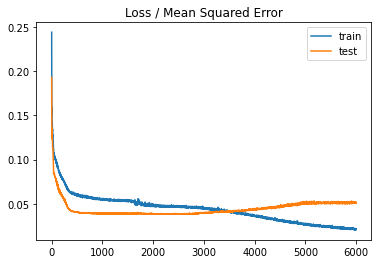

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


In [ ]:
def train_lstm(X_train, y_train, X_test, y_test, lstm_units, dropout_prob, epochs, batch_size):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))

    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True,
                input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_prob))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    # Adding the output layer
    model.add(Dense(units=1))

    # Adam optimizer
    opt = Adam(learning_rate=0.0005, epsilon=1e-06, decay=1e-06)
    # # PiecewiseConstantDecay optimizer
    # boundaries = [200, 800, 2000, 4000]
    # values = [0.01, 0.001, 0.0005, 0.0001, 0.00001]
    # opt = keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries, values)

    checkpoint = ModelCheckpoint("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss", monitor='val_loss', verbose=2,
                                 save_best_only=True, mode='auto')

    # Compiling the RNN
    # model.compile(optimizer = opt, loss = 'mean_squared_error')
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[checkpoint])

    # evaluate the model
    train_mse = model.evaluate(X_train, y_train)
    test_mse = model.evaluate(X_test, y_test)
    print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
    # plot loss during training
    plt.title('Loss / Mean Squared Error')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    return model

model = train_lstm(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lstm_units, dropout_prob, epochs, batch_size)
model.save('/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest')

### Test model

In [ ]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def calc_confusion_matrix(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    cm = confusion_matrix(y_true_direction, y_pred_direction, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()
    return cm

def calc_accuracy(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    return accuracy_score(y_true_direction, y_pred_direction)

In [ ]:
# X_test = X_train
lstm_model = keras.models.load_model("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss")

In [ ]:
#@title Define some params for make decision { run: "auto" }
min_price_change = 0 #@param {type:"number"}


In [ ]:
predicted_stock_price = lstm_model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [ ]:
y_test, predicted_stock_price

(array([[59.34000015],
        [63.09000015],
        [38.22999954],
        ...,
        [22.52000046],
        [14.60908318],
        [15.35000038]]), array([[60.39095  ],
        [62.971405 ],
        [38.009415 ],
        ...,
        [23.672485 ],
        [14.5460005],
        [15.285215 ]], dtype=float32))

In [ ]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[-1.05]
 [0.12]
 [0.22]
 ...
 [-1.15]
 [0.06]
 [0.06]]
[44533.38]


rmse: 1201.5570707050235 mape: 1.5704190326326473
confusion_matrix: [[235   0 451]
 [  0   0   0]
 [250   0 484]]
acc: 0.5063380281690141


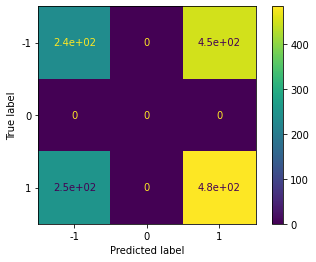

In [ ]:
# Calculate RMSE and MAPE
from sklearn.metrics import mean_squared_error

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

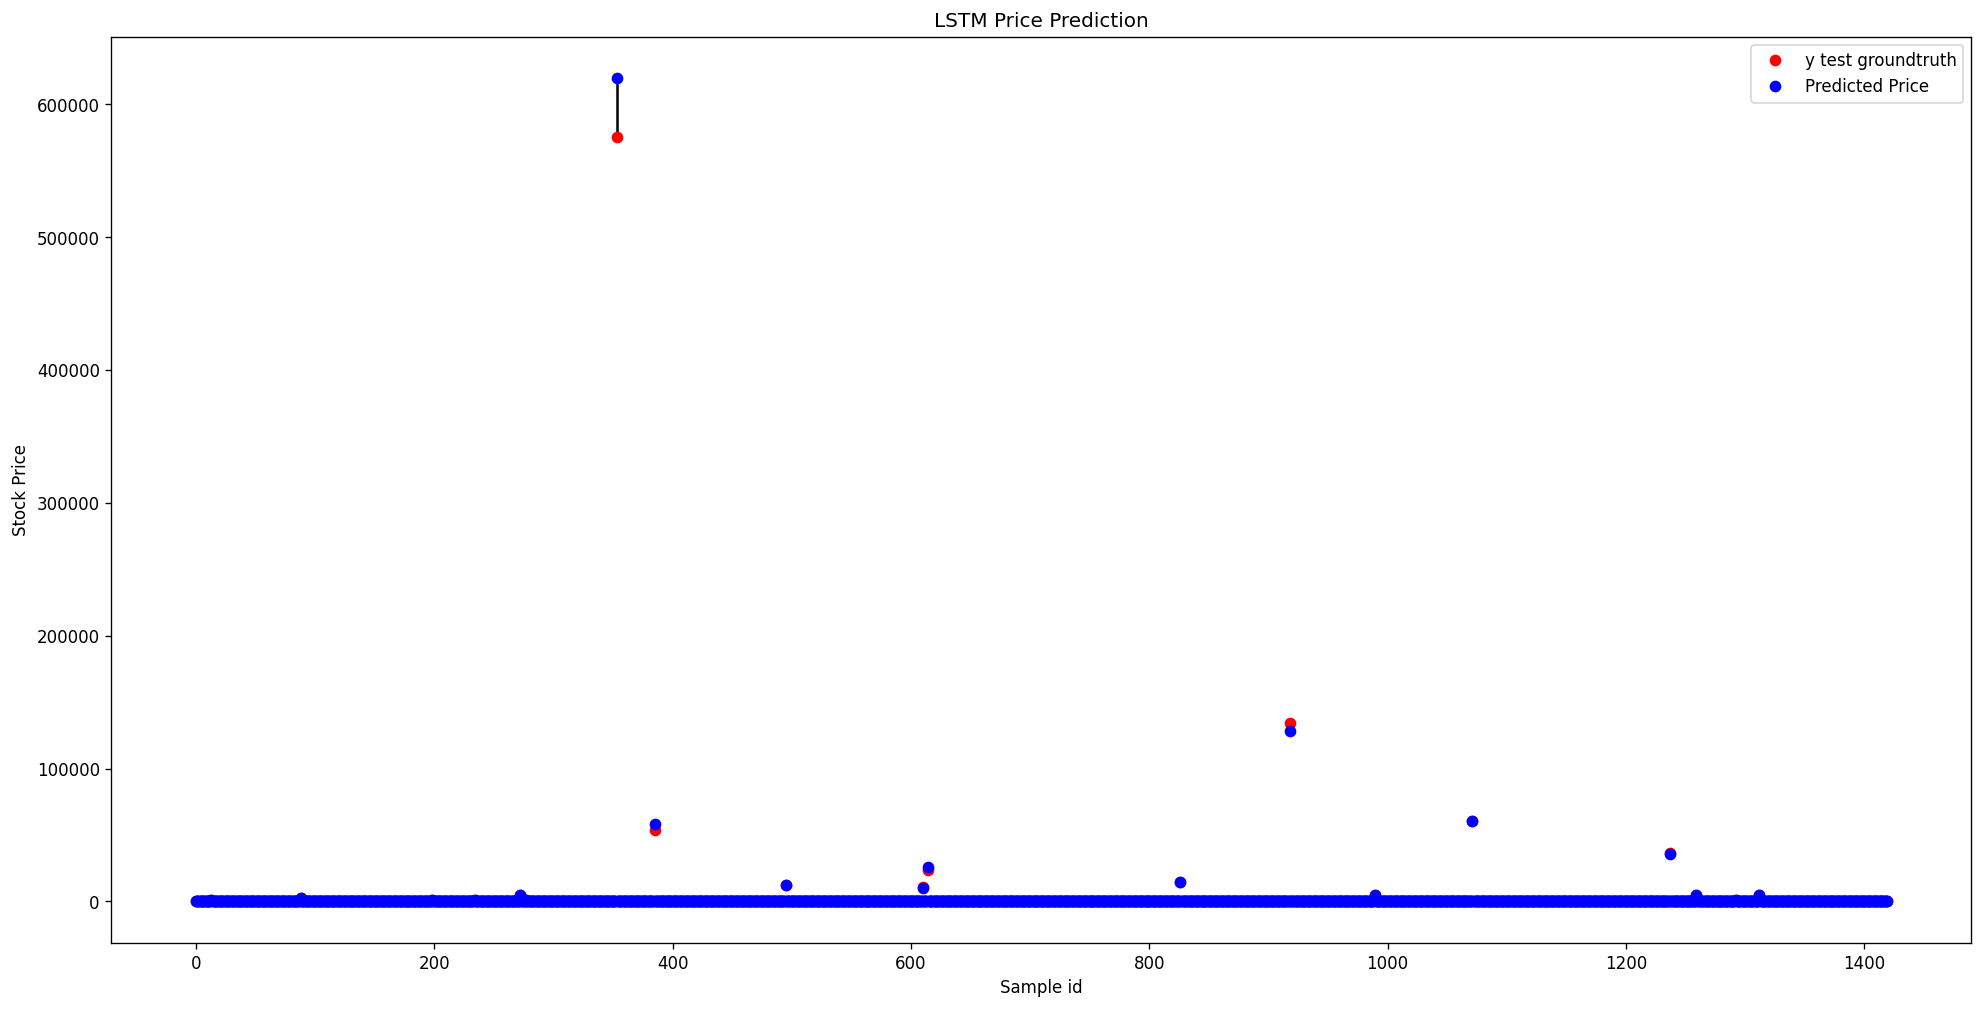

In [ ]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('LSTM Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## XGBoost model

### Build model

In [ ]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBRegressor

xgbmodel = XGBRegressor(seed=seed,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        colsample_bylevel=colsample_bylevel,
                        gamma=gamma)

### Train the model

In [ ]:
xgbmodel.fit(np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1])), np.reshape(y_train_scaled, (y_train_scaled.shape[0])))

[02:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

### Test model

In [ ]:
predicted_stock_price = xgbmodel.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1])))
predicted_stock_price = np.reshape(predicted_stock_price, (predicted_stock_price.shape[0], 1))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [ ]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[-0.84]
 [0.17]
 [0.31]
 ...
 [-1.08]
 [0.21]
 [0.01]]
[46228.75]


rmse: 1249.987682197711 mape: 1.5545145859383949
confusion_matrix: [[313   0 373]
 [  0   0   0]
 [308   0 426]]
acc: 0.5204225352112676


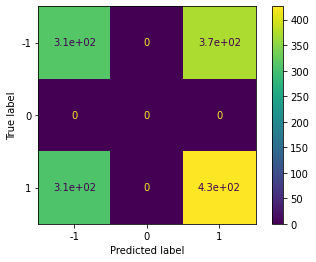

In [ ]:
rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

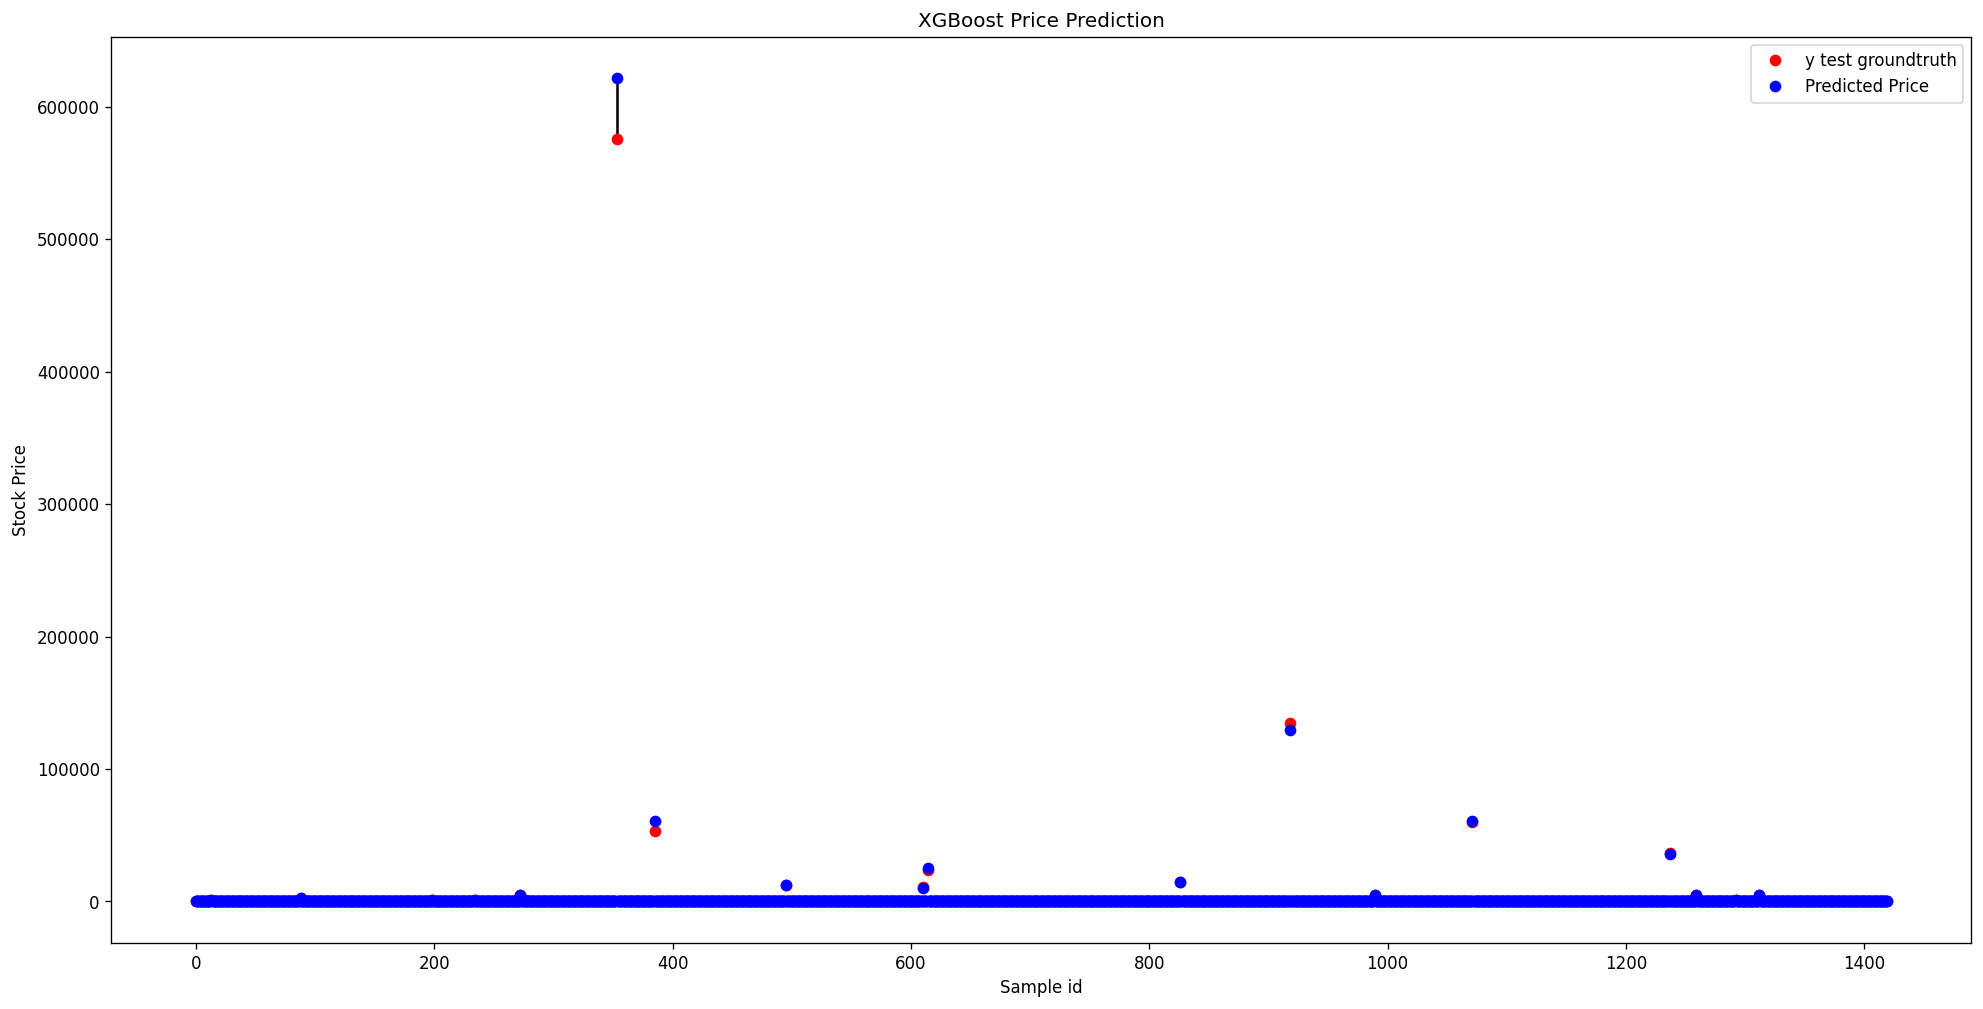

In [ ]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('XGBoost Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()